# Code Technical Debt Identification

| **Metrics**                     | **Description**                                                                                                                                                        |
|---------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `commits_count`                 | Total number of commits made to a file in the evolution period.                                                                                                         |
| `code_churn_avg`                | Average size of a code churn of a file in the evolution period.                                                                                                         |
| `contributors_count`            | Total number of contributors who modified a file in the evolution period.                                                                                               |
| `contributors_experience`       | Percentage of the lines authored by the highest contributor of a file in the evolution period.                                                                          |
| `hunks_count`                   | Median number of hunks made to a file in the evolution period. A hunk is a continuous block of changes in a diff. This assesses how fragmented the commit file is.      |
| `issue_tracker_issues`          | Total number of times a file name has been reported in the project's Jira or GitHub issue tracker (mentioned either in the title or the body of the registered issue).  |
| `cbo`                           | Coupling between objects. This metric counts the number of dependencies a file has.                                                                                     |
| `wmc`                           | Weight Method Class or McCabe’s complexity. This metric counts the number of branch instructions in a file.                                                             |
| `dit`                           | Depth Inheritance Tree. This metric counts the number of “fathers” a file has.                                                                                          |
| `rfc`                           | Response for a Class. This metric counts the number of unique method invocations in a file.                                                                             |
| `lcom`                          | Lack of Cohesion in Methods. This metric counts the sets of methods in a file that are not related through the sharing of some of the file’s fields.                    |
| `max_nested_blocks`             | Highest number of code blocks nested together in a file.                                                                                                               |
| `total_methods`                 | Total number of methods in a file.                                                                                                                                      |
| `total_variables`               | Total number of declared variables in a file.                                                                                                                           |
| `total_refactorings`            | Total number of refactorings for a file in the evolution period.                                                                                                        |
| `duplicated_lines_density`      | Percentage of lines in a file involved in duplications (100 * duplicated_lines / lines_of_code). The minimum length which should be reported as a duplicate is set to 100.|
| `comment_lines_density`         | Percentage of lines in a file containing either comment or commented-out code (100 * comment_lines / total number of physical lines). |
| `ncloc`                         | Number of non-commented lines of code in a file, ignoring empty lines and comments.                                                                                     |


## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import random
import numpy as np
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, log_loss, fbeta_score

from tensorflow.keras import Sequential, layers, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

#Oversampling
from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline

#dynamic table
#%pip install itables
from itables import init_notebook_mode, show

#Models
from sklearn.tree import DecisionTreeClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [ ]:
SEED_VALUE = 42
FEATURES = [
    'commits_count', 'code_churn_avg', 'contributors_count', 'contributors_experience', 
    'hunks_count', 'issue_tracker_issues', 'cbo', 'wmc', 'dit', 'rfc', 'lcom', 
    'total_methods', 'max_nested_blocks', 'total_variables', 'total_refactorings', 
    'ncloc_cloc', 'duplicated_lines_cpd_density', 'comment_lines_cloc_density'
]
random.seed(SEED_VALUE)

In [3]:
#ctd -> code technical debt - data frame
ctd_df = pd.read_csv('dataset_final.csv')

In [ ]:
ctd_df.head(10)

Max-Ruler  commits_count  code_churn_avg  contributors_count  \
0          1           11.0            65.0                 3.0   
1          1           34.0            29.0                 8.0   
2          1          184.0             5.0                12.0   
3          1           21.0            17.0                 6.0   
4          0           38.0            10.0                 6.0   
5          1           16.0            30.0                 4.0   
6          0           28.0             6.0                 9.0   
7          0            2.0            88.0                 1.0   
8          0            7.0            28.0                 1.0   
9          0           11.0            25.0                 4.0   

   contributors_experience  hunks_count  issue_tracker_issues   cbo    wmc  \
0                    81.63          1.0                    16   3.0  108.0   
1                    73.57          4.5                   217  14.0   46.0   
2                    37.28          2.0                    40  34.0  188.0   
3                    53.60          1.0                     9   9.0  103.0   
4                    52.14          2.5                     1  10.0   19.0   
5                    83.39          2.0                     2   8.0   53.0   
6                    58.56          1.0                     4   6.0   27.0   
7                   100.00          1.0                     0   8.0    8.0   
8                   100.00          6.0                     0   3.0   13.0   
9                    45.40          4.0                     0   5.0   12.0   

   dit    rfc    lcom  total_methods  max_nested_blocks  total_variables  \
0  1.0   74.0   774.0           40.0                3.0             66.0   
1  6.0  130.0   144.0           20.0                4.0             93.0   
2  1.0  163.0  1635.0           59.0                5.0            108.0   
3  1.0   36.0   183.0           26.0                4.0             30.0   
4  6.0   74.0    55.0           14.0                2.0             31.0   
5  6.0   78.0    94.0           17.0                6.0             38.0   
6  6.0   37.0   178.0           21.0                2.0             15.0   
7  6.0   36.0     1.0            3.0                3.0             21.0   
8  6.0   52.0    53.0           11.0                0.0             15.0   
9  6.0   40.0     9.0            6.0                1.0             20.0   

   total_refactorings  ncloc_cloc  duplicated_lines_cpd_density  \
0                  30       410.0                           0.0   
1                  41       799.0                           0.0   
2                 276       698.0                           0.0   
3                  14       310.0                           0.0   
4                  31       276.0                           0.0   
5                  14       347.0                           0.0   
6                  59       157.0                           0.0   
7                   0       125.0                           0.0   
8                   2       131.0                           0.0   
9                  59       198.0                           0.0   

   comment_lines_cloc_density  
0                   35.736677  
1                    4.540024  
2                   18.171161  
3                    0.958466  
4                   14.285714  
5                   12.814070  
6                    8.187135  
7                   18.831169  
8                   21.556886  
9                   17.154812

In [ ]:
ctd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17797 entries, 0 to 17796
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Max-Ruler                     17797 non-null  int64  
 1   commits_count                 17797 non-null  float64
 2   code_churn_avg                17797 non-null  float64
 3   contributors_count            17797 non-null  float64
 4   contributors_experience       17797 non-null  float64
 5   hunks_count                   17797 non-null  float64
 6   issue_tracker_issues          17797 non-null  int64  
 7   cbo                           17797 non-null  float64
 8   wmc                           17797 non-null  float64
 9   dit                           17797 non-null  float64
 10  rfc                           17797 non-null  float64
 11  lcom                          17797 non-null  float64
 12  total_methods                 17797 non-null  float64
 13  m

In [ ]:
ctd_df.describe()

Max-Ruler  commits_count  code_churn_avg  contributors_count  \
count  17797.000000   17797.000000    17797.000000        17797.000000   
mean       0.067034      11.110075       27.312862            3.499803   
std        0.250088      15.917221       44.888013            2.703207   
min        0.000000       1.000000       -2.000000            1.000000   
25%        0.000000       3.000000        9.000000            2.000000   
50%        0.000000       7.000000       16.000000            3.000000   
75%        0.000000      13.000000       30.000000            4.000000   
max        1.000000     317.000000     1543.000000           45.000000   

       contributors_experience   hunks_count  issue_tracker_issues  \
count             17797.000000  17797.000000          17797.000000   
mean                 77.906843      1.761758             10.083048   
std                  20.995250      1.265538             53.049656   
min                  17.640000      0.000000              0.000000   
25%                  60.490000      1.000000              0.000000   
50%                  82.950000      1.500000              0.000000   
75%                  98.320000      2.000000              3.000000   
max                 100.000000     26.500000           1187.000000   

                cbo           wmc           dit           rfc          lcom  \
count  17797.000000  17797.000000  17797.000000  17797.000000  17797.000000   
mean       7.440748     17.497556      2.037759     14.151205     63.580997   
std        7.904609     28.958399      1.837410     22.583650    331.961231   
min        0.000000      0.000000      1.000000      0.000000      0.000000   
25%        2.000000      3.000000      1.000000      1.000000      0.000000   
50%        5.000000      8.000000      1.000000      7.000000      2.000000   
75%       10.000000     19.000000      2.000000     17.000000     16.000000   
max      109.000000    453.000000     52.000000    293.000000   7503.000000   

       total_methods  max_nested_blocks  total_variables  total_refactorings  \
count   17797.000000       17797.000000     17797.000000        17797.000000   
mean        8.677137           1.311626         9.535427           15.658819   
std        12.042250           1.491109        18.302319           52.230184   
min         0.000000           0.000000         0.000000            0.000000   
25%         2.000000           0.000000         1.000000            1.000000   
50%         5.000000           1.000000         4.000000            1.000000   
75%        10.000000           2.000000        10.000000            9.000000   
max       256.000000          21.000000       305.000000         1024.000000   

         ncloc_cloc  duplicated_lines_cpd_density  comment_lines_cloc_density  
count  17797.000000                  17797.000000                17797.000000  
mean      97.528516                      4.851571                   39.143383  
std      142.377548                     20.257659                   21.790480  
min        2.000000                      0.000000                    0.000000  
25%       23.000000                      0.000000                   22.368421  
50%       51.000000                      0.000000                   36.363636  
75%      110.000000                      0.000000                   53.703704  
max     1903.000000                    537.500000                   94.117647

## Exploratory Analysis

Amount of classes classified as HIGH_TD: 1193
Amount of classes classified as LOW_TD: 16604


/var/folders/h7/q0630v0j18n1580txfr75yx80000gn/T/ipykernel_3146/1874346689.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


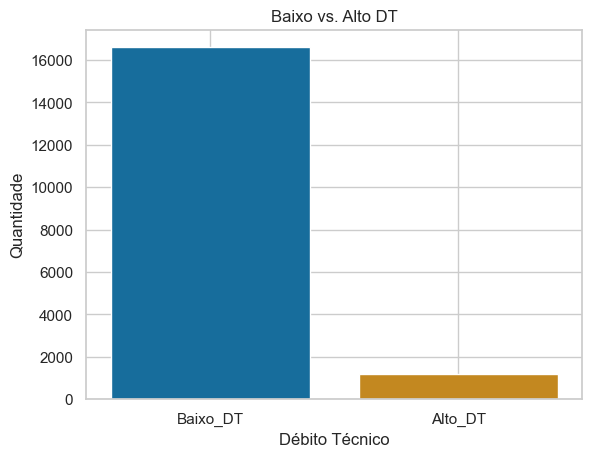

In [5]:
print(f"Amount of classes classified as HIGH_TD: {ctd_df[ctd_df['Max-Ruler'] == 1]['Max-Ruler'].count()}")
print(f"Amount of classes classified as LOW_TD: {ctd_df[ctd_df['Max-Ruler'] == 0]['Max-Ruler'].count()}")

sns.set_theme(style="whitegrid")
sns.countplot(
    x='Max-Ruler', 
    data=ctd_df, 
    palette="colorblind"
)


plt.xlabel('Débito Técnico')
plt.ylabel('Quantidade')
plt.title('Baixo vs. Alto DT')
plt.xticks([0, 1], ['Baixo_DT', 'Alto_DT'])
plt.grid(True) 
plt.show()

From the histogram plot, we can say that the number of values in each class is enormously different. So we have a imbalance in the dataset, it will be necessary to use techniques such as SMOTE to over sambple the class with lower amount.

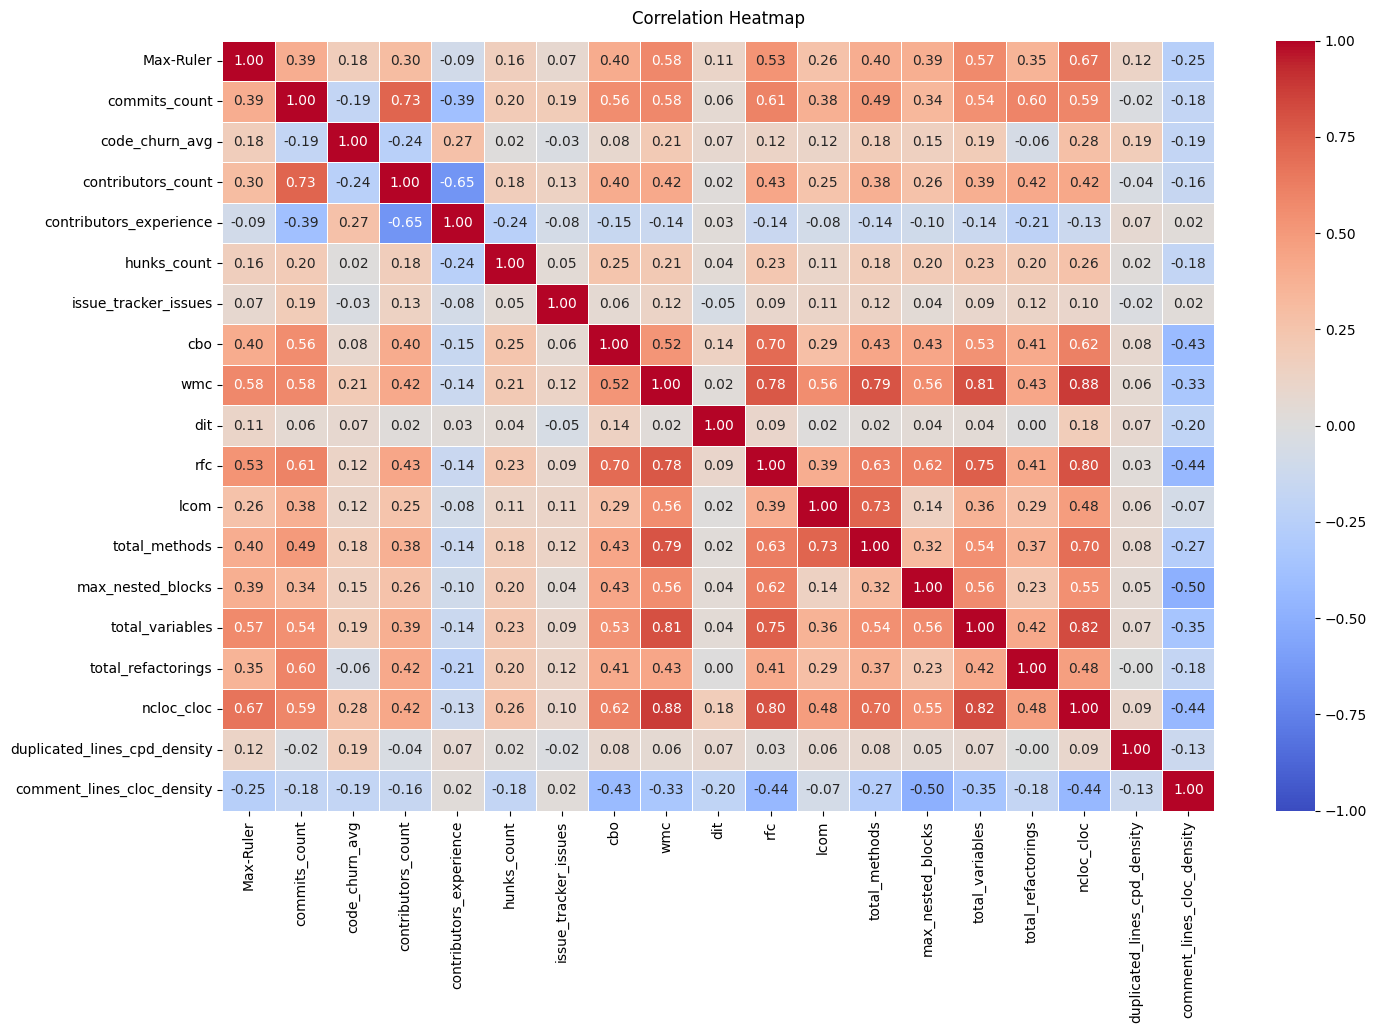

In [4]:
plt.figure(figsize=(16, 10))

correlation_matrix_ctd_df = ctd_df.corr()
heatmap = sns.heatmap(correlation_matrix_ctd_df, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [5]:
correlation_with_target = correlation_matrix_ctd_df['Max-Ruler'].sort_values(ascending=False)
print(correlation_with_target)

Max-Ruler                       1.000000
ncloc_cloc                      0.668636
wmc                             0.583348
total_variables                 0.573347
rfc                             0.531118
cbo                             0.403588
total_methods                   0.397916
commits_count                   0.391241
max_nested_blocks               0.386397
total_refactorings              0.353933
contributors_count              0.303366
lcom                            0.263870
code_churn_avg                  0.177297
hunks_count                     0.164536
duplicated_lines_cpd_density    0.118188
dit                             0.113966
issue_tracker_issues            0.072261
contributors_experience        -0.089087
comment_lines_cloc_density     -0.252737
Name: Max-Ruler, dtype: float64


In [13]:
# Extracting the correlations of Max-Ruler with all other features
feature_correlation = correlation_matrix_ctd_df['Max-Ruler'].drop('Max-Ruler')

# Converting the correlations to a DataFrame for easier plotting
correlation_df = feature_correlation.reset_index()
correlation_df.columns = ['Feature', 'Correlation']

correlation_df = correlation_df.sort_values(by='Correlation', ascending=False).head(5)

fig = px.bar(correlation_df.sort_values(by='Correlation', ascending=True), x='Correlation', y='Feature', orientation='h',
             title='Correlação do Max-Ruler com outras features',
             labels={'Correlation': 'Correlação', 'Feature': 'Feature'})

fig.show()

## Data Split

In [11]:
X = ctd_df.drop('Max-Ruler', axis=1)
y = ctd_df['Max-Ruler']

# creation of train and test dataset
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED_VALUE, stratify=y)
X_train_splited, X_valid, y_train_splited, y_valid = train_test_split(X_train_all, y_train_all, test_size=0.1765, random_state=SEED_VALUE, stratify=y_train_all)
#Train 70% Test 15% Valid 15%

## Create Pipeline

In [20]:
def create_pipeline(model):
        return Pipeline(steps=[
                ('over', SMOTE(sampling_strategy=1,random_state=SEED_VALUE)),
                ('scale', MinMaxScaler()), 
                ('model', model)
        ])

In [4]:
def create_pipeline_scaler_model(model):
        return Pipeline(steps=[
                ('scale', MinMaxScaler()), 
                ('model', model)
        ])

In [3]:
def create_pipeline_with(technique, model):
        return Pipeline(steps=[
            ('technique', technique),
            ('scale', MinMaxScaler()), 
            ('model', model)
    ])

## Metrics

In [14]:
#How well does the model perform when it's more important to avoid false negatives than false positives?
                                                                   #High-TD classes that are classified as Low-TD
f2_score = metrics.make_scorer(metrics.fbeta_score, beta=2)

## Util Functions

In [ ]:
def plot_metrics(df):
    # Plot 1: Grouped Bar Plot for Accuracy, Precision, Recall, F1, F2 Scores
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'f2_score']
    df_melted = df.melt(id_vars='Sampler', value_vars=metrics, var_name='Metric', value_name='Score')
    fig1 = px.bar(df_melted, x='Sampler', y='Score', color='Metric', barmode='group', 
                  title='Comparison of Accuracy, Precision, Recall, F1, F2 Scores')
    fig1.update_layout(xaxis_tickangle=-45)
    
    # Plot 2: Heatmap for Log Loss and Best Score (with text annotations)
    heatmap_data = df[['Sampler', 'log_loss', 'best_score']].set_index('Sampler')
    fig2 = go.Figure(data=go.Heatmap(
        z=heatmap_data.values,
        x=heatmap_data.columns,
        y=heatmap_data.index,
        colorscale='Viridis',
        text=heatmap_data.values, 
        hoverinfo='text',
        showscale=True
    ))

    annotations = []
    for i, row in enumerate(heatmap_data.index):
        for j, col in enumerate(heatmap_data.columns):
            annotations.append(
                go.layout.Annotation(
                    x=col, 
                    y=row, 
                    text=f"{heatmap_data.iloc[i, j]:.4f}",
                    showarrow=False,
                    font=dict(color="white" if heatmap_data.iloc[i, j] > 0.5 else "black"),  # Adjusting color based on value
                )
            )
    fig2.update_layout(title='Log Loss and Best Score Heatmap', annotations=annotations)

    # Plot 3: Stacked Bar Plot for TP, FP, FN, TN
    fig3 = go.Figure()
    for col in ['TN', 'FP', 'FN', 'TP']:
        fig3.add_trace(go.Bar(x=df['Sampler'], y=df[col], name=col))
    fig3.update_layout(barmode='stack', title='Stacked Bar Plot of TP, FP, FN, TN', xaxis_tickangle=-45)

    # Plot 4: Line Plot for Precision and Recall
    fig4 = go.Figure()
    fig4.add_trace(go.Scatter(x=df['Sampler'], y=df['precision'], mode='lines+markers', name='Precision'))
    fig4.add_trace(go.Scatter(x=df['Sampler'], y=df['recall'], mode='lines+markers', name='Recall'))
    fig4.update_layout(title='Precision and Recall by Sampler', xaxis_tickangle=-45)

    # Plot 5: Box Plot for Accuracy, Precision, Recall, F1, F2 Scores
    fig5 = px.box(df_melted, x='Metric', y='Score', title='Box Plot of Accuracy, Precision, Recall, F1, F2 Scores')

    # Show all figures
    fig1.show()
    fig2.show()
    fig3.show()
    fig4.show()
    fig5.show()

In [40]:
def evaluate(X_test, y_test, grid_search=None, model=None, print_res=True):

    if model is None and grid_search is not None:
        model = grid_search.best_estimator_

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    #Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    cm = confusion_matrix(y_test, y_pred)
    logloss = log_loss(y_test, y_prob)
    auc_roc = roc_auc_score(y_test, y_prob[:, 1])

    #Get the best parameters and best score
    if grid_search is not None:
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

    #Print the evaluation results
    if print_res:
        print(f"{'='*40}\nEvaluation Metrics\n{'='*40}")

        if grid_search is not None:
                print(f"Best Parameters : {best_params}")
                print(f"Best Grid Search Score: {best_score:.4f}")

        print(f"Accuracy  : {accuracy:.4f}")
        print(f"Precision : {precision:.4f}")
        print(f"Recall    : {recall:.4f}")
        print(f"F1-Score  : {f1:.4f}")
        print(f"Log-Loss  : {logloss:.4f}")
        print(f"AUC-ROC   : {auc_roc:.4f}")
        print(f"F2-Score   : {f2:.4f}")
        print(f"{'='*40}\n")

        # Print detailed classification report
        print("\nClassification Report:\n")
        print(classification_report(y_test, y_pred))

        # Create a confusion matrix heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix', fontsize=12)
        plt.ylabel('Actual', fontsize=10)
        plt.xlabel('Predicted', fontsize=10)
        plt.show()

    def_res = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'f2_score': f2,
        'log_loss': logloss,
        'auc_roc': auc_roc,
        'confusion_matrix': cm
    }

    if grid_search != None:
        def_res['best_params'] = best_params
        def_res['best_score'] = best_score

    return def_res

In [4]:
def plot_grouped_bar_comparison(dataframe, metrics):
    # Melt the DataFrame to long format
    melted_df = dataframe.melt(id_vars="model", value_vars=metrics, var_name="Metric", value_name="Value")
    
    # Create a grouped bar chart with metrics on the x-axis and models distinguished by color
    fig = px.bar(
        melted_df,
        x="Metric",       # Metrics on the x-axis
        y="Value",        # Values of each model for the metric on the y-axis
        color="model",    # Color by model
        barmode="group",  # Group bars by metric
        title="Comparison of Models across Metrics",
        labels={"Value": "Metric Value", "Metric": "Metric"}
    )
    
    fig.update_layout(
        yaxis=dict(range=[0, 1]),
        uniformtext_minsize=8, 
        uniformtext_mode='hide'
    )
    
    fig.show()

In [22]:
def evaluate_old(grid_search, X_test, y_test):
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)  # Probabilities for log-loss and AUC-ROC

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    logloss = log_loss(y_test, y_prob)
    auc_roc = roc_auc_score(y_test, y_prob[:, 1])

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Print the evaluation results
    print(f"{'='*40}\nEvaluation Metrics\n{'='*40}")

    print(f"Best Parameters : {best_params}")
    print(f"Best Grid Search Score: {best_score:.4f}")

    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1-Score  : {f1:.4f}")
    print(f"Log-Loss  : {logloss:.4f}")
    print(f"AUC-ROC   : {auc_roc:.4f}")
    print(f"{'='*40}\n")

    # Print detailed classification report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Create a confusion matrix heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Low-TD', 'Predicted High-TD'], 
                yticklabels=['Actual Low-TD', 'Actual HIgh-TD'])
    plt.title('Confusion Matrix', fontsize=12)
    plt.ylabel('Actual', fontsize=10)
    plt.xlabel('Predicted', fontsize=10)
    plt.show()

    return {
        'best_params': best_params,
        'best_score': best_score,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'log_loss': logloss,
        'auc_roc': auc_roc,
        'confusion_matrix': cm
    }

## Models Training

### DecisionTree
- Best Parameters : {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
- Best Grid Search Score (f2-score): 0.7205
- Accuracy  : 0.8918

In [29]:
dt_classifier = DecisionTreeClassifier(random_state=SEED_VALUE)
pipeline = create_pipeline(dt_classifier)
scores = cross_val_score(pipeline, X_train_all, y_train_all, cv=10, scoring='accuracy')

In [30]:
print("Average cross-validation score:", scores.mean())

Average cross-validation score: 0.940996538320215


In [31]:
pipeline.fit(X_train_all, y_train_all)
y_pred = pipeline.predict(X_test)

In [32]:
#evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Accuracy: 0.9398876404494382
Precision: 0.5403050108932462
Recall: 0.6927374301675978
F1-score: 0.6070991432068543
Confusion matrix:
 [[4771  211]
 [ 110  248]]


In [33]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4982
           1       0.54      0.69      0.61       358

    accuracy                           0.94      5340
   macro avg       0.76      0.83      0.79      5340
weighted avg       0.95      0.94      0.94      5340



Grid Search

In [34]:
dt_classifier = DecisionTreeClassifier(random_state=SEED_VALUE)
param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

In [35]:
pipeline = create_pipeline(dt_classifier)

grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring = {
        'accuracy': 'accuracy',
        'f2': f2_score
}, cv = 10, n_jobs = -1, refit='f2',verbose=1)

In [36]:
dt_grid_result = grid_search.fit(X_train_all, y_train_all)
dt_grid_result

Fitting 10 folds for each of 72 candidates, totalling 720 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 5, 10, 15],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10]},
             refit='f2',
             scoring={'accuracy': 'accuracy',
                      'f2': make_scorer(fbeta_score, response_method='predict', beta=2)},
             verbose=1)

In [37]:
print("Best hyperparameters:", dt_grid_result.best_params_)
print("Best score:", dt_grid_result.best_score_)

Best hyperparameters: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best score: 0.7204939908571406


Evaluation Metrics
Best Parameters : {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best Grid Search Score: 0.7205
Accuracy  : 0.8918
Precision : 0.3772
Recall    : 0.9441
F1-Score  : 0.5391
Log-Loss  : 0.2237
AUC-ROC   : 0.9660
F2-Score   : 0.7259


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      4982
           1       0.38      0.94      0.54       358

    accuracy                           0.89      5340
   macro avg       0.69      0.92      0.74      5340
weighted avg       0.95      0.89      0.91      5340



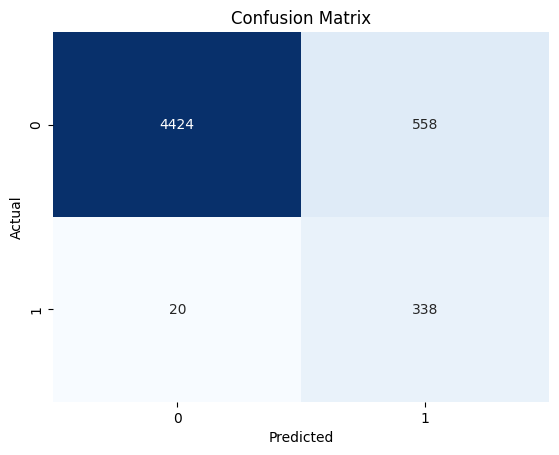

In [62]:
dt_result = evaluate(X_test, y_test, grid_search=dt_grid_result)

### Random Forest
- Best Parameters : {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__n_estimators': 300}
- Best Grid Search Score (f2-score): 0.7812
- Accuracy  : 0.9466

In [40]:
model = RandomForestClassifier(random_state=SEED_VALUE, n_jobs=-1)
pipeline = create_pipeline(model)
param_grid = {
    'model__n_estimators': [5, 10, 50, 100, 300, 500, 1000],
    'model__max_depth': [None, 2, 5, 10, 20, 30, 40],
    'model__min_samples_leaf': [1, 2, 5],
    'model__criterion': ['gini', 'entropy']
}

In [41]:
grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring = {
        'accuracy': 'accuracy',
        'f2': f2_score
}, cv = 10, n_jobs = -1, refit='f2',verbose=1)

In [42]:
rf_grid_result = grid_search.fit(X_train_all, y_train_all)
rf_grid_result

Fitting 10 folds for each of 294 candidates, totalling 2940 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 2, 5, 10, 20, 30, 40],
                         'model__min_samples_leaf': [1, 2, 5],
                         'model__n_estimators': [5, 10, 50, 100, 300, 500,
                                                 1000]},
             refit='f2',
             scoring={'accuracy': 'accuracy',
                      'f2': make_scorer(fbeta_score, response_method='predict', beta=2)},
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__n_estimators': 300}
Best Grid Search Score: 0.7812
Accuracy  : 0.9466
Precision : 0.5720
Recall    : 0.8101
F1-Score  : 0.6705
Log-Loss  : 0.1145
AUC-ROC   : 0.9774
F2-Score   : 0.7478


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4982
           1       0.57      0.81      0.67       358

    accuracy                           0.95      5340
   macro avg       0.78      0.88      0.82      5340
weighted avg       0.96      0.95      0.95      5340



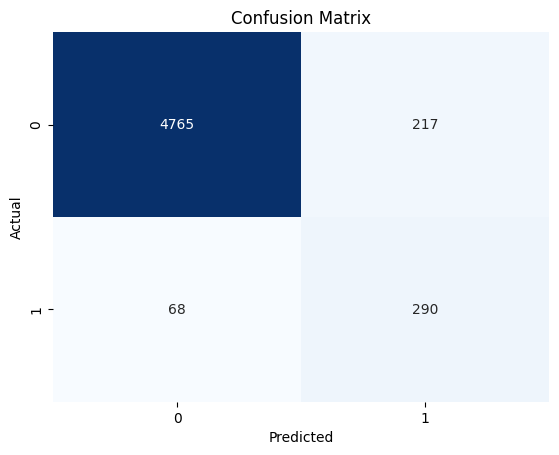

In [63]:
rf_result = evaluate(X_test, y_test, grid_search=rf_grid_result)

#### Testing without smote

In [33]:
model = RandomForestClassifier(random_state=SEED_VALUE, n_jobs=-1, class_weight='balanced')
pipeline = create_pipeline_scaler_model(model)
param_grid = {
    'model__n_estimators': [5, 10, 50, 100, 300, 500, 1000],
    'model__max_depth': [None, 2, 5, 10, 20, 30, 40],
    'model__min_samples_leaf': [1, 2, 5],
    'model__criterion': ['gini', 'entropy']
}

In [ ]:
grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, 
                           scoring=f2_score, cv = 10, 
                           n_jobs = -1,verbose=1)

In [35]:
rf_grid_result_without_smote = grid_search.fit(X_train_all, y_train_all)
rf_grid_result_without_smote

Fitting 10 folds for each of 294 candidates, totalling 2940 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 2, 5, 10, 20, 30, 40],
                         'model__min_samples_leaf': [1, 2, 5],
                         'model__n_estimators': [5, 10, 50, 100, 300, 500,
                                                 1000]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__n_estimators': 50}
Best Grid Search Score: 0.7716
Accuracy  : 0.9449
Precision : 0.5588
Recall    : 0.8492
F1-Score  : 0.6741
Log-Loss  : 0.1214
AUC-ROC   : 0.9763
F2-Score   : 0.7692


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4982
           1       0.56      0.85      0.67       358

    accuracy                           0.94      5340
   macro avg       0.77      0.90      0.82      5340
weighted avg       0.96      0.94      0.95      5340



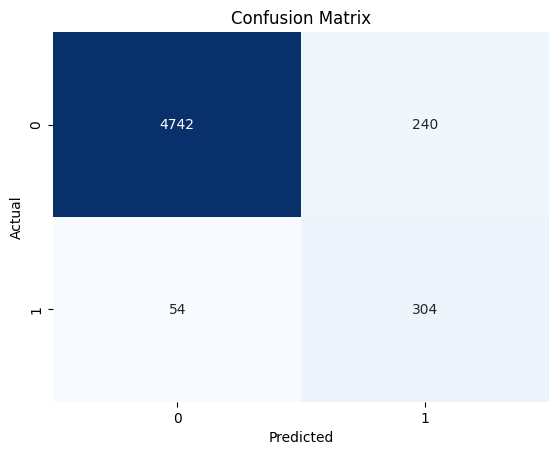

In [36]:
rf_result_without_smote = evaluate(X_test, y_test, grid_search=rf_grid_result_without_smote )

### KerasClassifier
- Best Parameters : {'model__model__activation': 'relu', 'model__model__neurons': 200, 'model__model__num_hidden_layers': 2, 'model__model__optimizer': 'adam'}
- Best Grid Search Score (f2-score): 0.7548
- Accuracy  : 0.9307

In [54]:
#buil model func
def build_model(activation='relu', neurons=128, num_hidden_layers=2, optimizer='adam'):
  model = Sequential()
  model.add(Input(shape=(X_train_splited.shape[1], )))
  model.add(Dense(neurons, activation=activation))

  # Add hidden layers
  num_hidden_layers -= 1
  for _ in range(num_hidden_layers):
    model.add(Dense(neurons, activation=activation))

  # Output layer
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [55]:
model = KerasClassifier(model=build_model, epochs=10, batch_size=64, verbose=1, random_state=SEED_VALUE)

pipeline = create_pipeline(model)

# hyperparameters to search
param_grid = {
    'model__model__activation': ['relu', 'sigmoid'],
    'model__model__neurons': [128, 200, 300, 400, 500],
    'model__model__num_hidden_layers': [2, 3, 4, 5],
    'model__model__optimizer': ['adam', 'rmsprop', 'sgd']
}

#GridSearch
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=f2_score, cv=10, n_jobs=-1)

# Run the grid search
k_grid_result = grid.fit(X_train_splited, y_train_splited, model__validation_data=(X_valid, y_valid))
k_grid_result

Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8843 - loss: 0.3776 - val_accuracy: 0.2315 - val_loss: 412.4213
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8846 - loss: 0.3772 - val_accuracy: 0.2356 - val_loss: 439.7952
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8807 - loss: 0.3796 - val_accuracy: 0.2256 - val_loss: 439.2293
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8804 - loss: 0.3807 - val_accuracy: 0.2210 - val_loss: 446.9456
Epoch 2/10
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8827 - loss: 0.3772 - val_accuracy: 0.2242 - val_loss: 420.4467
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8783 - loss: 0.3854 - val_accuracy: 0.2206 - val_loss: 480.6731
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8832 - loss: 0.3786 - val_accuracy: 0.2287 - val_loss: 420.1334
Epoch 2/10
27

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        KerasClassifier(batch_size=64, epochs=10, model=<function build_model at 0x317e2bc70>, random_state=42))]),
             n_jobs=-1,
             param_grid={'model__model__activation': ['relu', 'sigmoid'],
                         'model__model__neurons': [128, 200, 300, 400, 500],
                         'model__model__num_hidden_layers': [2, 3, 4, 5],
                         'model__model__optimizer': ['adam', 'rmsprop', 'sgd']},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
Evaluation Metrics
Best Parameters : {'model__model__activation': 'relu', 'model__model__neurons': 200, 'model__model__num_hidden_layers': 2, 'model__model__optimizer': 'adam'}
Best Grid Search Score: 0.7549
Accuracy  : 0.9307
Precision : 0.4902
Recall    : 0.8408
F1-Score  : 0.6193
Log-Loss  : 0.1485
AUC-ROC   : 0.9721
F2-Score   : 0.7356


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      4982
           1       0.49      0.84      0.62       358

    accuracy                           0.93      5340
   macro avg       0.74      0.89      0.79      5340
weighted avg       0.95      0.93      0.94      5340



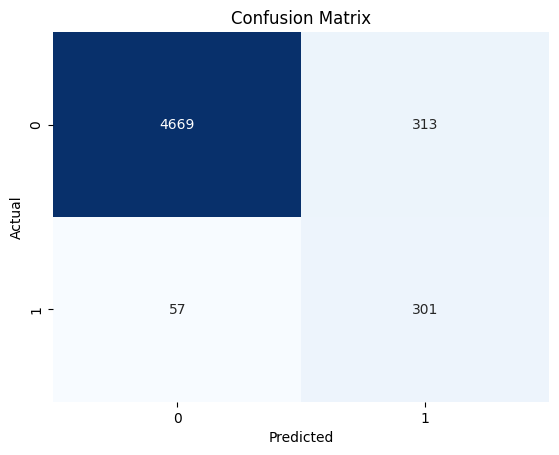

In [64]:
# Display best result with hyperparameters
k_result = evaluate(X_test, y_test, grid_search=k_grid_result)

### K-NN
- Best Parameters : {'model__algorithm': 'auto', 'model__leaf_size': 10, 'model__metric': 'manhattan', 'model__n_neighbors': 9, 'model__p': 1, 'model__weights': 'distance'}
- Best Grid Search Score (f2-score): 0.7561
- Accuracy  : 0.9202

In [45]:
model = KNeighborsClassifier(n_jobs=-1)

pipeline = create_pipeline(model)

param_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan', 'minkowski'],
    'model__p': [1, 2],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'model__leaf_size': [10, 20, 30, 40]
}

grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=f2_score, cv=10, n_jobs=-1, verbose=2)

# Run the grid search
knn_grid_result = grid.fit(X_train_all, y_train_all)
knn_grid_result

Fitting 10 folds for each of 960 candidates, totalling 9600 fits
[CV] END model__algorithm=auto, model__leaf_size=10, model__metric=euclidean, model__n_neighbors=3, model__p=1, model__weights=uniform; total time=   0.4s
[CV] END model__algorithm=auto, model__leaf_size=10, model__metric=euclidean, model__n_neighbors=3, model__p=1, model__weights=uniform; total time=   0.4s
[CV] END model__algorithm=auto, model__leaf_size=10, model__metric=euclidean, model__n_neighbors=3, model__p=1, model__weights=uniform; total time=   0.4s
[CV] END model__algorithm=auto, model__leaf_size=10, model__metric=euclidean, model__n_neighbors=3, model__p=1, model__weights=uniform; total time=   0.4s
[CV] END model__algorithm=auto, model__leaf_size=10, model__metric=euclidean, model__n_neighbors=3, model__p=1, model__weights=uniform; total time=   0.4s
[CV] END model__algorithm=auto, model__leaf_size=10, model__metric=euclidean, model__n_neighbors=3, model__p=1, model__weights=uniform; total time=   0.5s
[CV] 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'model__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                              'brute'],
                         'model__leaf_size': [10, 20, 30, 40],
                         'model__metric': ['euclidean', 'manhattan',
                                           'minkowski'],
                         'model__n_neighbors': [3, 5, 7, 9, 11],
                         'model__p': [1, 2],
                         'model__weights': ['uniform', 'distance']},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=2)

Evaluation Metrics
Best Parameters : {'model__algorithm': 'auto', 'model__leaf_size': 10, 'model__metric': 'manhattan', 'model__n_neighbors': 9, 'model__p': 1, 'model__weights': 'distance'}
Best Grid Search Score: 0.7561
Accuracy  : 0.9202
Precision : 0.4499
Recall    : 0.8520
F1-Score  : 0.5888
Log-Loss  : 0.6829
AUC-ROC   : 0.9559
F2-Score   : 0.7227


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      4982
           1       0.45      0.85      0.59       358

    accuracy                           0.92      5340
   macro avg       0.72      0.89      0.77      5340
weighted avg       0.95      0.92      0.93      5340



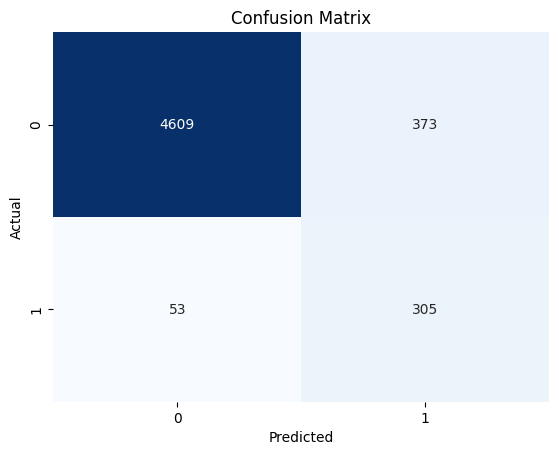

In [65]:
# Display best result with hyperparameters
knn_result = evaluate(X_test, y_test, grid_search=knn_grid_result)

### SVM
- Best Parameters : {'model__C': 10, 'model__class_weight': None, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
- Best Grid Search Score (f2-score): 0.7656
- Accuracy  : 0.9200

In [ ]:
model = SVC(random_state=SEED_VALUE, probability=True)

pipeline = create_pipeline(model)

param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'model__class_weight': [None, 'balanced']
}

grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=f2_score, cv=10, n_jobs=-1, verbose=2)

# Run the grid search
svm_grid_result = grid.fit(X_train_all, y_train_all)
svm_grid_result

Evaluation Metrics
Best Parameters : {'model__C': 10, 'model__class_weight': None, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Best Grid Search Score: 0.7656
Accuracy  : 0.9200
Precision : 0.4539
Recall    : 0.9497
F1-Score  : 0.6143
Log-Loss  : 0.2281
AUC-ROC   : 0.9782
F2-Score   : 0.7795


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      4982
           1       0.45      0.95      0.61       358

    accuracy                           0.92      5340
   macro avg       0.73      0.93      0.78      5340
weighted avg       0.96      0.92      0.93      5340



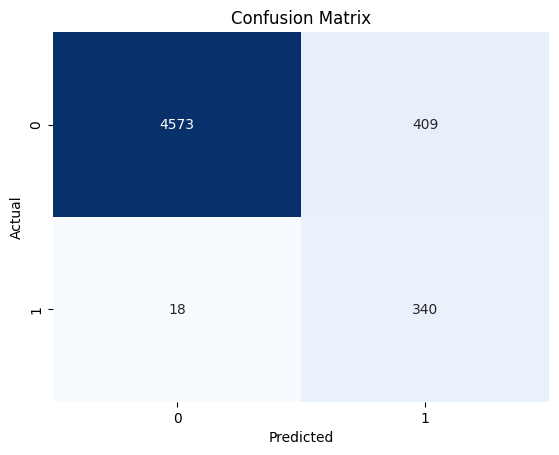

In [ ]:
# Display best result with hyperparameters
svm_result = evaluate(X_test, y_test, grid_search=svm_grid_result)

#### Testing without smote
- Overall it was better
- But recall had a significant decrease

In [ ]:
model = SVC(random_state=SEED_VALUE, probability=True)

pipeline = create_pipeline_scaler_model(model)

param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'model__class_weight': [{0: 1, 1:4},None, 'balanced']
}

grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=f2_score, cv=10, n_jobs=-1, verbose=2)

# Run the grid search
svm_grid_result_without_smote = grid.fit(X_train_all, y_train_all)
svm_grid_result_without_smote

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV] END model__C=0.1, model__class_weight={0: 1, 1: 4}, model__gamma=scale, model__kernel=linear; total time=  10.9s
[CV] END model__C=0.1, model__class_weight={0: 1, 1: 4}, model__gamma=scale, model__kernel=linear; total time=  11.0s
[CV] END model__C=0.1, model__class_weight={0: 1, 1: 4}, model__gamma=scale, model__kernel=linear; total time=  11.2s
[CV] END model__C=0.1, model__class_weight={0: 1, 1: 4}, model__gamma=scale, model__kernel=linear; total time=  11.2s
[CV] END model__C=0.1, model__class_weight={0: 1, 1: 4}, model__gamma=scale, model__kernel=linear; total time=  11.3s
[CV] END model__C=0.1, model__class_weight={0: 1, 1: 4}, model__gamma=scale, model__kernel=linear; total time=  11.4s
[CV] END model__C=0.1, model__class_weight={0: 1, 1: 4}, model__gamma=scale, model__kernel=linear; total time=  11.5s
[CV] END model__C=0.1, model__class_weight={0: 1, 1: 4}, model__gamma=scale, model__kernel=linear; total time

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('model',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__class_weight': [{0: 1, 1: 4}, None,
                                                 'balanced'],
                         'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                         'model__kernel': ['linear', 'rbf']},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=2)

Evaluation Metrics
Best Parameters : {'model__C': 10, 'model__class_weight': {0: 1, 1: 4}, 'model__gamma': 1, 'model__kernel': 'rbf'}
Best Grid Search Score: 0.7648
Accuracy  : 0.9539
Precision : 0.6197
Recall    : 0.8101
F1-Score  : 0.7022
Log-Loss  : 0.0948
AUC-ROC   : 0.9768
F2-Score   : 0.7632


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      4982
           1       0.62      0.81      0.70       358

    accuracy                           0.95      5340
   macro avg       0.80      0.89      0.84      5340
weighted avg       0.96      0.95      0.96      5340



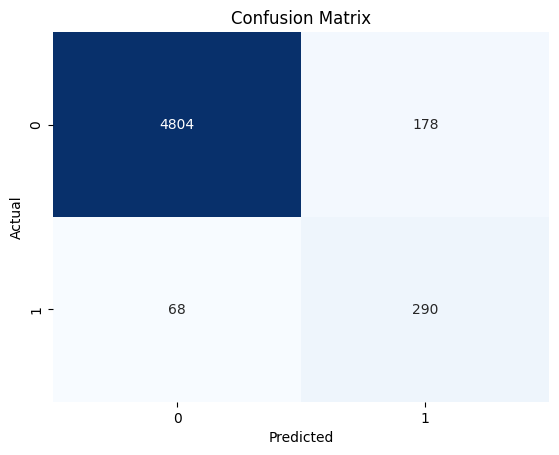

In [ ]:
# Display best result with hyperparameters
svm_result_without_smote = evaluate(X_test, y_test, grid_search=svm_grid_result_without_smote)

### XGBoost
- Best Parameters : {'model__colsample_bytree': 0.6, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 50, 'model__subsample': 1.0}
- Best Grid Search Score: 0.7711
- Accuracy  : 0.9399

In [34]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

pipeline = create_pipeline(model)

param_grid = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [3, 4, 5],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=f2_score, cv=10, n_jobs=-1, verbose=2)

# Run the grid search
xgboost_grid_result = grid.fit(X_train_all, y_train_all)
xgboost_grid_result

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.6; total time=   0.2s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.6; total time=   0.2s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.6; total time=   0.2s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.6; total time=   0.2s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.6; total time=   0.2s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.6; total time=   0.2s
[CV] END model__colsample_bytree=0.

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.6, 0.8, 1.0],
                         'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [50, 100, 150],
                         'model__subsample': [0.6, 0.8, 1.0]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=2)

Evaluation Metrics
Best Parameters : {'model__colsample_bytree': 0.6, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 50, 'model__subsample': 1.0}
Best Grid Search Score: 0.7711
Accuracy  : 0.9399
Precision : 0.5332
Recall    : 0.8296
F1-Score  : 0.6492
Log-Loss  : 0.1271
AUC-ROC   : 0.9770
F2-Score   : 0.7466


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4982
           1       0.53      0.83      0.65       358

    accuracy                           0.94      5340
   macro avg       0.76      0.89      0.81      5340
weighted avg       0.96      0.94      0.95      5340



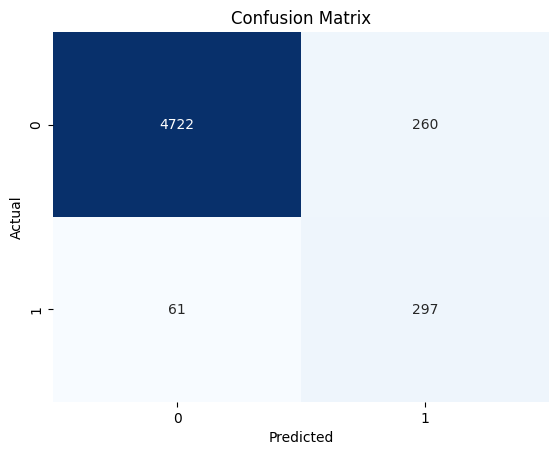

In [37]:
xgboost_result = evaluate(X_test, y_test, grid_search=xgboost_grid_result)

#### Test without smote
- Not better

In [17]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

pipeline = create_pipeline_scaler_model(model)

param_grid = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [3, 4, 5],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=f2_score, cv=10, n_jobs=-1, verbose=2)

# Run the grid search
xgboost_grid_result_without_smote = grid.fit(X_train_all, y_train_all)
xgboost_grid_result_without_smote

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.6; total time=   0.2s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.6; total time=   0.2s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.6; total time=   0.1s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.6; total time=   0.2s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.6; total time=   0.2s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.6; total time=   0.2s
[CV] END model__colsample_bytree=0.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_ty...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.6, 0.8, 1.0],
                         'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [50, 100, 150],
                         'model__subsample': [0.6, 0.8, 1.0]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=2)

Evaluation Metrics
Best Parameters : {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 150, 'model__subsample': 0.8}
Best Grid Search Score: 0.6839
Accuracy  : 0.9652
Precision : 0.7905
Recall    : 0.6536
F1-Score  : 0.7156
Log-Loss  : 0.0859
AUC-ROC   : 0.9802
F2-Score   : 0.6771


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4982
           1       0.79      0.65      0.72       358

    accuracy                           0.97      5340
   macro avg       0.88      0.82      0.85      5340
weighted avg       0.96      0.97      0.96      5340



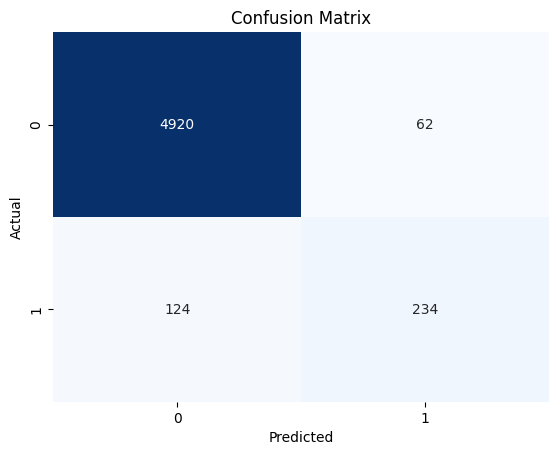

In [18]:
xgboost_result_without_smote = evaluate(X_test, y_test, grid_search=xgboost_grid_result_without_smote)

### Result Table

In [ ]:
grid_results = {
    'KNN': knn_result,
    'Keras': k_result,
    'SVM': svm_result,
    'DT': dt_result,
    'RF': rf_result,
    'XGBoost': xgboost_result
}

In [20]:
def grid_results_to_dataframe(grid_results, entity = "model"):
    rows = []
    for _, grid_result in grid_results.items():
        
        if 'confusion_matrix' in grid_result:
            cm = grid_result['confusion_matrix']
            # True Negative (TN), False Positive (FP), False Negative (FN), True Positive (TP) 
            TN, FP = cm[0]
            FN, TP = cm[1]
        else:
            TP = FP = FN = TN = None

        # Exclude 'confusion_matrix' and 'best_params' from the main result dictionary
        df_row = {k: v for k, v in grid_result.items() if k not in ['confusion_matrix', 'best_params']}
        df_row['TP'] = TP
        df_row['FP'] = FP 
        df_row['FN'] = FN
        df_row['TN'] = TN

        df_row['best_params'] = str(grid_result.get('best_params', {}))

        rows.append(df_row)
    
    
    df = pd.DataFrame(rows)
    df.insert(0, entity, list(grid_results.keys()))
    return df

In [ ]:
#xgboost_dt = grid_results_to_dataframe({'XGBoost':xgboost_result})
#results_dt = pd.read_csv('gs_model_results.csv', index_col=False)
#df_grid_results = pd.concat([results_dt, xgboost_dt], ignore_index=True)
#df_grid_results

In [2]:
df_grid_results = pd.read_csv('results/gs_smote_model_results_2.csv', index_col=False)#grid_results_to_dataframe(grid_results)
#df_grid_results


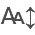

In [48]:
init_notebook_mode()
show(df_grid_results, buttons=["columnsToggle"])

In [ ]:
metrics_to_plot = ["accuracy", "precision", "recall", "f1_score", "f2_score", "log_loss", "auc_roc", "best_score"]
plot_grouped_bar_comparison(df_grid_results, metrics_to_plot)

In [51]:
#df_grid_results.to_csv("results/gs_smote_model_results_2.csv", index=False)

## Other Experimental Tests

### RF

In [14]:
#{'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__n_estimators': 300}
model = RandomForestClassifier(random_state=SEED_VALUE, n_jobs=-1, criterion='gini', max_depth=None, min_samples_leaf=5, n_estimators=300)
pipeline = create_pipeline(model)
pipeline.fit(X_train_all, y_train_all)
score = pipeline.score(X_test, y_test)
score

0.9466292134831461

Evaluation Metrics
Accuracy  : 0.9466
Precision : 0.5720
Recall    : 0.8101
F1-Score  : 0.6705
Log-Loss  : 0.1145
AUC-ROC   : 0.9774
F2-Score   : 0.7478


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4982
           1       0.57      0.81      0.67       358

    accuracy                           0.95      5340
   macro avg       0.78      0.88      0.82      5340
weighted avg       0.96      0.95      0.95      5340



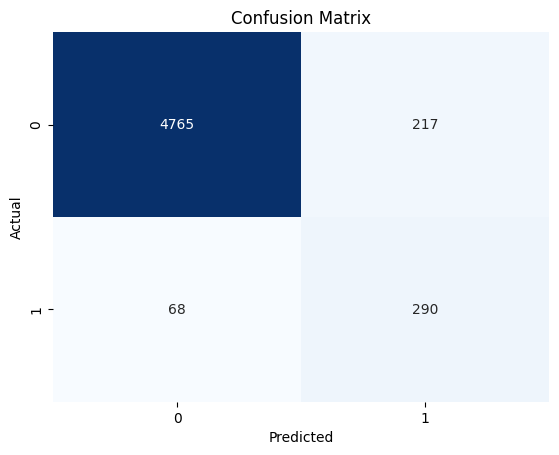

{'accuracy': 0.9466292134831461,
 'precision': 0.571992110453649,
 'recall': 0.8100558659217877,
 'f1_score': 0.6705202312138728,
 'f2_score': 0.7478081485301702,
 'log_loss': 0.11454724539271993,
 'auc_roc': 0.9773547900934987,
 'confusion_matrix': array([[4765,  217],
        [  68,  290]])}

In [46]:
evaluate(X_test, y_test, model=pipeline)

In [42]:
model = RandomForestClassifier(random_state=SEED_VALUE, n_jobs=-1, criterion='gini', max_depth=None, min_samples_leaf=5, n_estimators=300)
pipeline = create_pipeline(model)
pipeline.fit(X_train_all, y_train_all)
scores = cross_val_score(pipeline, X_train_all, y_train_all, cv=20, scoring=f2_score, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min finished


In [43]:
print(f"Cross-validation F2-score: {scores}")
print(f"Mean F2-score: {scores.mean()}")

Cross-validation F2-score: [0.82159624 0.73059361 0.74889868 0.84090909 0.78475336 0.74889868
 0.80912863 0.81545064 0.72072072 0.75221239 0.81140351 0.8008658
 0.77625571 0.84070796 0.82278481 0.69196429 0.78947368 0.77433628
 0.78828829 0.72072072]
Mean F2-score: 0.7794981550617575


Evaluation Metrics
Accuracy  : 0.9466
Precision : 0.5720
Recall    : 0.8101
F1-Score  : 0.6705
Log-Loss  : 0.1145
AUC-ROC   : 0.9774
F2-Score   : 0.7478


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4982
           1       0.57      0.81      0.67       358

    accuracy                           0.95      5340
   macro avg       0.78      0.88      0.82      5340
weighted avg       0.96      0.95      0.95      5340



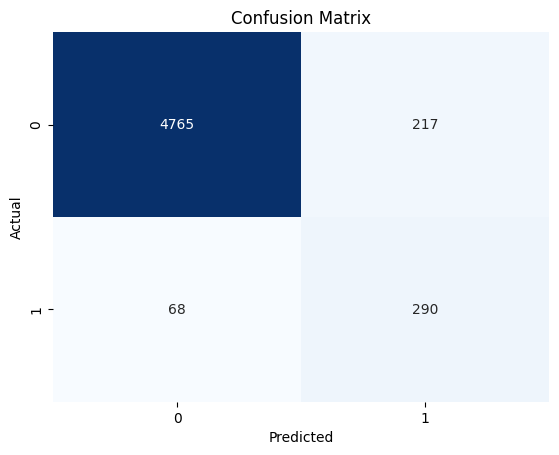

{'accuracy': 0.9466292134831461,
 'precision': 0.571992110453649,
 'recall': 0.8100558659217877,
 'f1_score': 0.6705202312138728,
 'f2_score': 0.7478081485301702,
 'log_loss': 0.11454724539271993,
 'auc_roc': 0.9773547900934987,
 'confusion_matrix': array([[4765,  217],
        [  68,  290]])}

In [44]:
evaluate(X_test, y_test, model=pipeline)

### Testing other Oversampling and Undersampling techniques

In [26]:
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN

In [79]:
sampling_techniques = {
    #Oversampling
    "RandomOverSampler": RandomOverSampler(sampling_strategy=1, random_state=SEED_VALUE),
    "ADASYN": ADASYN(sampling_strategy=1, random_state=SEED_VALUE),
    #Downsampling
    "RandomUnderSampler": RandomUnderSampler(sampling_strategy=1, random_state=SEED_VALUE),
    "TomekLinks": TomekLinks(sampling_strategy='majority', n_jobs=-1),
    #Combines over and down sampling
    "SMOTEENN": SMOTEENN(sampling_strategy=1, random_state=SEED_VALUE),
    "smote": SMOTE(sampling_strategy=1,random_state=SEED_VALUE)
}

In [65]:
def create_grid_search(model, sampling_technique, grid_params):
        pipeline = create_pipeline_with(sampling_technique, model)

        return GridSearchCV(estimator = pipeline, param_grid = grid_params, scoring =f2_score, cv = 10, n_jobs = -1,verbose=1)

#### **=== Random Forest ===**

In [42]:
param_grid = {
    'model__n_estimators': [5, 10, 50, 100, 300, 500, 1000],
    'model__max_depth': [None, 2, 5, 10, 20, 30, 40],
    'model__min_samples_leaf': [1, 2, 5],
    'model__criterion': ['gini', 'entropy']
}

##### Random Over Sampler

In [43]:
model = RandomForestClassifier(random_state=SEED_VALUE, n_jobs=-1)
pipeline = create_pipeline_with(sampling_techniques["RandomOverSampler"], model)

In [44]:
grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring =f2_score, cv = 10, n_jobs = -1,verbose=1)

In [45]:
rf_grid_result = grid_search.fit(X_train_all, y_train_all)
rf_grid_result

Fitting 10 folds for each of 294 candidates, totalling 2940 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('technique',
                                        RandomOverSampler(random_state=42,
                                                          sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 2, 5, 10, 20, 30, 40],
                         'model__min_samples_leaf': [1, 2, 5],
                         'model__n_estimators': [5, 10, 50, 100, 300, 500,
                                                 1000]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_leaf': 5, 'model__n_estimators': 100}
Best Grid Search Score: 0.7762
Accuracy  : 0.9408
Precision : 0.5368
Recall    : 0.8547
F1-Score  : 0.6595
Log-Loss  : 0.1267
AUC-ROC   : 0.9767
F2-Score   : 0.7642


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4982
           1       0.54      0.85      0.66       358

    accuracy                           0.94      5340
   macro avg       0.76      0.90      0.81      5340
weighted avg       0.96      0.94      0.95      5340



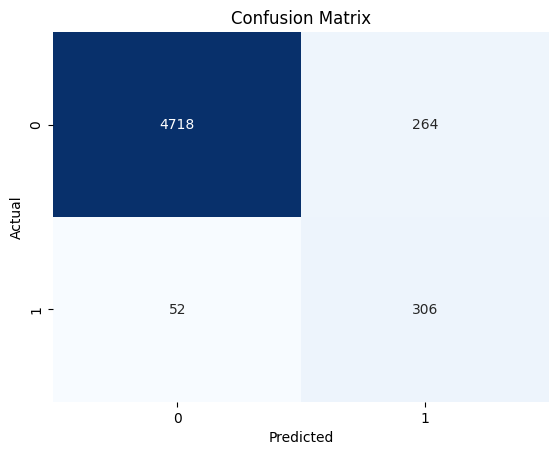

In [46]:
rf_over_random_result = evaluate(X_test, y_test, rf_grid_result)

##### ADASYN

In [47]:
model = RandomForestClassifier(random_state=SEED_VALUE, n_jobs=-1)
pipeline = create_pipeline_with(sampling_techniques["ADASYN"], model)
grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring =f2_score, cv = 10, n_jobs = -1,verbose=1)
rf_grid_result = grid_search.fit(X_train_all, y_train_all)
rf_grid_result

Fitting 10 folds for each of 294 candidates, totalling 2940 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('technique',
                                        ADASYN(random_state=42,
                                               sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 2, 5, 10, 20, 30, 40],
                         'model__min_samples_leaf': [1, 2, 5],
                         'model__n_estimators': [5, 10, 50, 100, 300, 500,
                                                 1000]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 5, 'model__n_estimators': 300}
Best Grid Search Score: 0.7826
Accuracy  : 0.9478
Precision : 0.5804
Recall    : 0.7961
F1-Score  : 0.6714
Log-Loss  : 0.1148
AUC-ROC   : 0.9772
F2-Score   : 0.7410


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4982
           1       0.58      0.80      0.67       358

    accuracy                           0.95      5340
   macro avg       0.78      0.88      0.82      5340
weighted avg       0.96      0.95      0.95      5340



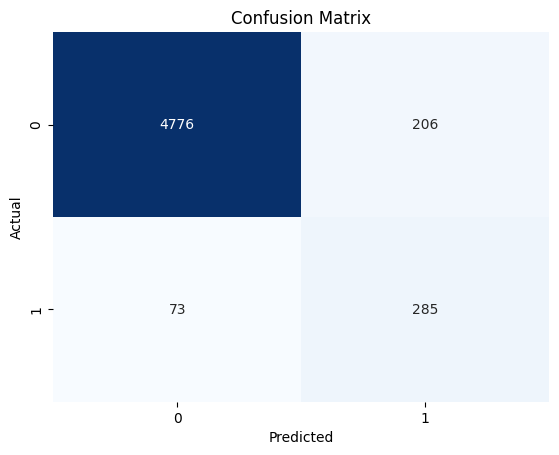

In [48]:
rf_over_adasyn_result = evaluate(X_test, y_test, rf_grid_result)

##### Random Under Sampler

In [49]:
model = RandomForestClassifier(random_state=SEED_VALUE, n_jobs=-1)
pipeline = create_pipeline_with(sampling_techniques["RandomUnderSampler"], model)
grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring =f2_score, cv = 10, n_jobs = -1,verbose=1)
rf_grid_result = grid_search.fit(X_train_all, y_train_all)
rf_grid_result

Fitting 10 folds for each of 294 candidates, totalling 2940 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('technique',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 2, 5, 10, 20, 30, 40],
                         'model__min_samples_leaf': [1, 2, 5],
                         'model__n_estimators': [5, 10, 50, 100, 300, 500,
                                                 1000]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 10}
Best Grid Search Score: 0.7490
Accuracy  : 0.9094
Precision : 0.4186
Recall    : 0.9050
F1-Score  : 0.5724
Log-Loss  : 0.6616
AUC-ROC   : 0.9635
F2-Score   : 0.7344


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      4982
           1       0.42      0.91      0.57       358

    accuracy                           0.91      5340
   macro avg       0.71      0.91      0.76      5340
weighted avg       0.95      0.91      0.92      5340



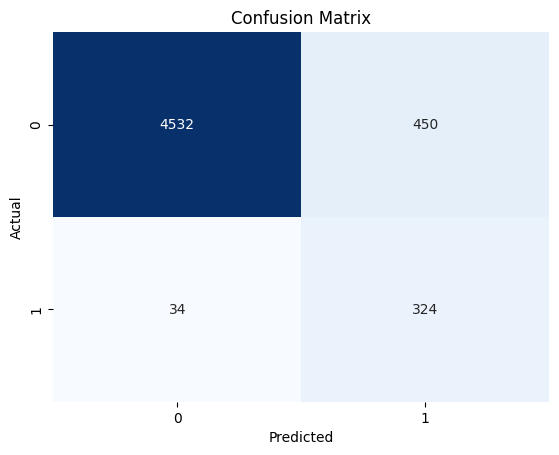

In [50]:
rf_under_random_result = evaluate(X_test, y_test, rf_grid_result)

##### Tomeklinks

In [51]:
model = RandomForestClassifier(random_state=SEED_VALUE, n_jobs=-1)
pipeline = create_pipeline_with(sampling_techniques["TomekLinks"], model)
grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring =f2_score, cv = 10, n_jobs = -1,verbose=1)
rf_grid_result = grid_search.fit(X_train_all, y_train_all)
rf_grid_result

Fitting 10 folds for each of 294 candidates, totalling 2940 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('technique',
                                        TomekLinks(n_jobs=-1,
                                                   sampling_strategy='majority')),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 2, 5, 10, 20, 30, 40],
                         'model__min_samples_leaf': [1, 2, 5],
                         'model__n_estimators': [5, 10, 50, 100, 300, 500,
                                                 1000]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__criterion': 'gini', 'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__n_estimators': 1000}
Best Grid Search Score: 0.6918
Accuracy  : 0.9657
Precision : 0.7850
Recall    : 0.6732
F1-Score  : 0.7248
Log-Loss  : 0.0872
AUC-ROC   : 0.9793
F2-Score   : 0.6929


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4982
           1       0.79      0.67      0.72       358

    accuracy                           0.97      5340
   macro avg       0.88      0.83      0.85      5340
weighted avg       0.96      0.97      0.96      5340



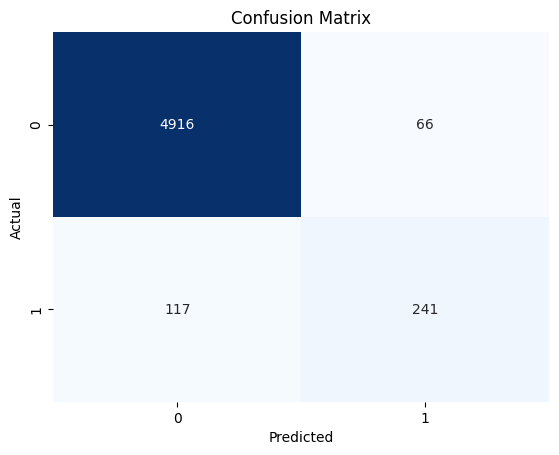

In [52]:
rf_under_tomeklinks_result = evaluate(X_test, y_test, rf_grid_result)

##### SMOTEENN

In [53]:
model = RandomForestClassifier(random_state=SEED_VALUE, n_jobs=-1)
pipeline = create_pipeline_with(sampling_techniques["SMOTEENN"], model)
grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring =f2_score, cv = 10, n_jobs = -1,verbose=1)
rf_grid_result = grid_search.fit(X_train_all, y_train_all)
rf_grid_result

Fitting 10 folds for each of 294 candidates, totalling 2940 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('technique',
                                        SMOTEENN(random_state=42,
                                                 sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 2, 5, 10, 20, 30, 40],
                         'model__min_samples_leaf': [1, 2, 5],
                         'model__n_estimators': [5, 10, 50, 100, 300, 500,
                                                 1000]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 100}
Best Grid Search Score: 0.7768
Accuracy  : 0.9307
Precision : 0.4908
Recall    : 0.8939
F1-Score  : 0.6337
Log-Loss  : 0.2437
AUC-ROC   : 0.9760
F2-Score   : 0.7678


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      4982
           1       0.49      0.89      0.63       358

    accuracy                           0.93      5340
   macro avg       0.74      0.91      0.80      5340
weighted avg       0.96      0.93      0.94      5340



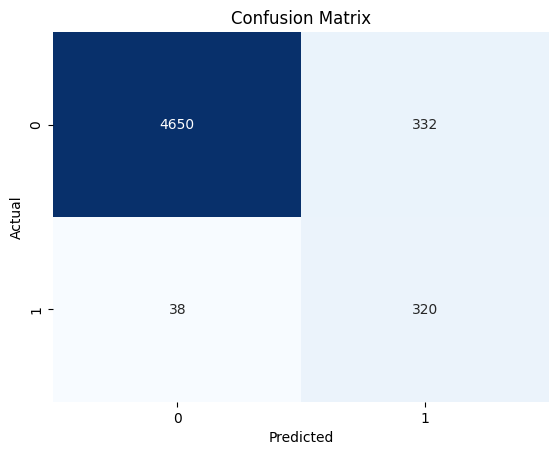

In [54]:
rf_combined_smoteenn_result = evaluate(X_test, y_test, rf_grid_result)

##### Results

In [55]:
# rf_sampling_techniques = {
#     #Oversampling
#     "RandomOverSampler": rf_over_random_result,
#     "ADASYN": rf_over_adasyn_result,
#     #Downsampling
#     "RandomUnderSampler": rf_under_random_result,
#     "TomekLinks": rf_under_tomeklinks_result,
#     #Combines over and down sampling
#     "SMOTEENN": rf_combined_smoteenn_result
# }

# rf_df = grid_results_to_dataframe(rf_sampling_techniques, entity="Sampler")

In [56]:
# df_grid_results = pd.read_csv("results/gs_smote_model_results_2.csv", index_col=False)
# filtered_df = df_grid_results[df_grid_results["model"] == "RF"]
# filtered_df = filtered_df.rename(columns={"model": "Sampler"})

# filtered_df["Sampler"] = "smote"

# rf_df = pd.concat([rf_df, filtered_df], ignore_index=True)

In [ ]:
# rf_df = pd.concat([rf_df, grid_results_to_dataframe({"without":rf_result_without_smote}, entity="Sampler")], ignore_index=True)
# rf_df

In [7]:
rf_df = pd.read_csv('results/rf_sampler_results.csv', index_col=False)

show(rf_df, buttons=["columnsToggle"])

- The model with None sampler had the best performance?
- It had the highest f2score
- The f1score was the second highest
- In the overall analysis of the precision and recall it peformed pretty well
- The accuracy didnt change much from one sampler to another

smoteenn

In [12]:
plot_metrics(rf_df)

In [59]:
# rf_df.to_csv("results/rf_sampler_results.csv", index=False)

#### **=== XGBoost ===**

In [66]:
param_grid = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [3, 4, 5],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

##### Random Oversampling

In [67]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid = create_grid_search(model, sampling_techniques["RandomOverSampler"], param_grid)
grid.fit(X_train_all, y_train_all)
grid

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('technique',
                                        RandomOverSampler(random_state=42,
                                                          sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.6, 0.8, 1.0],
                         'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [50, 100, 150],
                         'model__subsample': [0.6, 0.8, 1.0]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__colsample_bytree': 0.6, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 150, 'model__subsample': 0.8}
Best Grid Search Score: 0.7743
Accuracy  : 0.9328
Precision : 0.4992
Recall    : 0.8575
F1-Score  : 0.6310
Log-Loss  : 0.1439
AUC-ROC   : 0.9774
F2-Score   : 0.7499


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      4982
           1       0.50      0.86      0.63       358

    accuracy                           0.93      5340
   macro avg       0.74      0.90      0.80      5340
weighted avg       0.96      0.93      0.94      5340



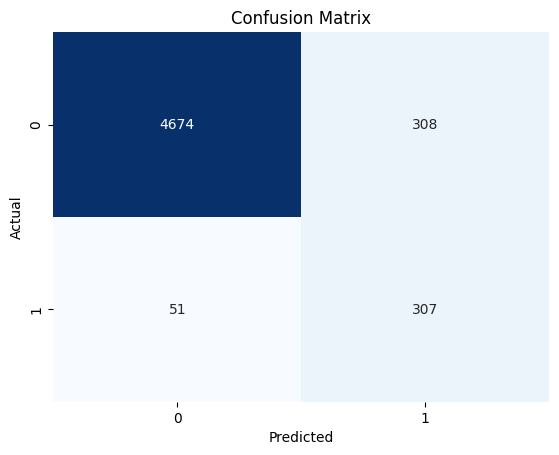

In [68]:
xgboost_over_random_result = evaluate(X_test, y_test, grid)

##### ADASYN

In [69]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid = create_grid_search(model, sampling_techniques["ADASYN"], param_grid)
grid.fit(X_train_all, y_train_all)
grid

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('technique',
                                        ADASYN(random_state=42,
                                               sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      fe...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.6, 0.8, 1.0],
                         'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [50, 100, 150],
                         'model__subsample': [0.6, 0.8, 1.0]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 50, 'model__subsample': 0.6}
Best Grid Search Score: 0.7702
Accuracy  : 0.9356
Precision : 0.5115
Recall    : 0.8715
F1-Score  : 0.6446
Log-Loss  : 0.1346
AUC-ROC   : 0.9769
F2-Score   : 0.7640


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      4982
           1       0.51      0.87      0.64       358

    accuracy                           0.94      5340
   macro avg       0.75      0.91      0.80      5340
weighted avg       0.96      0.94      0.94      5340



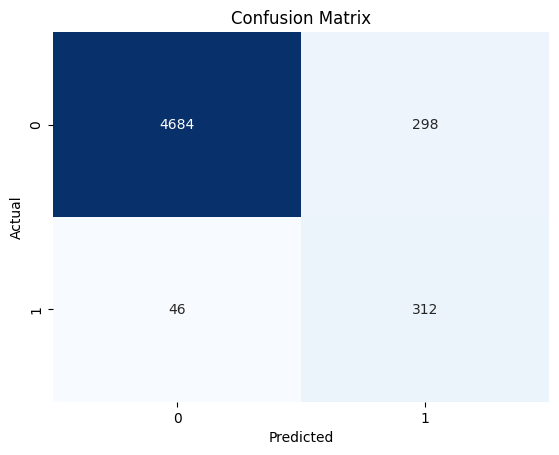

In [70]:
xgboost_over_adasyn_result = evaluate(X_test, y_test, grid)

##### Random Undersampler

In [71]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid = create_grid_search(model, sampling_techniques["RandomUnderSampler"], param_grid)
grid.fit(X_train_all, y_train_all)
grid

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('technique',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.6, 0.8, 1.0],
                         'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [50, 100, 150],
                         'model__subsample': [0.6, 0.8, 1.0]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 50, 'model__subsample': 0.6}
Best Grid Search Score: 0.7539
Accuracy  : 0.9081
Precision : 0.4164
Recall    : 0.9246
F1-Score  : 0.5742
Log-Loss  : 0.2056
AUC-ROC   : 0.9743
F2-Score   : 0.7432


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      4982
           1       0.42      0.92      0.57       358

    accuracy                           0.91      5340
   macro avg       0.71      0.92      0.76      5340
weighted avg       0.96      0.91      0.92      5340



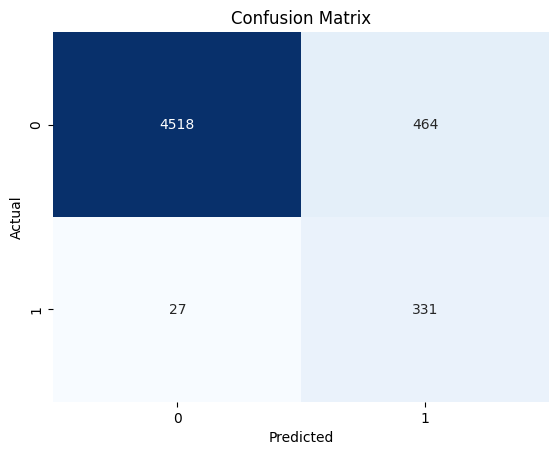

In [72]:
xgboost_under_random_result = evaluate(X_test, y_test, grid)

##### Tomelinks

In [73]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid = create_grid_search(model, sampling_techniques["TomekLinks"], param_grid)
grid.fit(X_train_all, y_train_all)
grid

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('technique',
                                        TomekLinks(n_jobs=-1,
                                                   sampling_strategy='majority')),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logl...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.6, 0.8, 1.0],
                         'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [50, 100, 150],
                         'model__subsample': [0.6, 0.8, 1.0]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 150, 'model__subsample': 1.0}
Best Grid Search Score: 0.7105
Accuracy  : 0.9652
Precision : 0.7688
Recall    : 0.6872
F1-Score  : 0.7257
Log-Loss  : 0.0875
AUC-ROC   : 0.9796
F2-Score   : 0.7021


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4982
           1       0.77      0.69      0.73       358

    accuracy                           0.97      5340
   macro avg       0.87      0.84      0.85      5340
weighted avg       0.96      0.97      0.96      5340



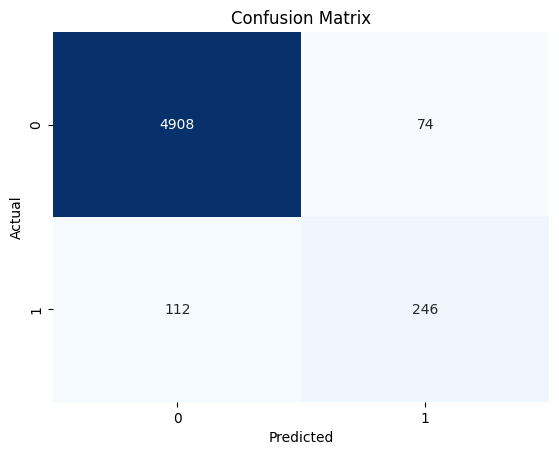

In [74]:
xgboost_under_tomeklinks_result = evaluate(X_test, y_test, grid)

##### SMOTEENN

In [75]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid = create_grid_search(model, sampling_techniques["SMOTEENN"], param_grid)
grid.fit(X_train_all, y_train_all)
grid

Fitting 10 folds for each of 243 candidates, totalling 2430 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('technique',
                                        SMOTEENN(random_state=42,
                                                 sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.6, 0.8, 1.0],
                         'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [50, 100, 150],
                         'model__subsample': [0.6, 0.8, 1.0]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 100, 'model__subsample': 0.8}
Best Grid Search Score: 0.7751
Accuracy  : 0.9382
Precision : 0.5233
Recall    : 0.8799
F1-Score  : 0.6562
Log-Loss  : 0.2156
AUC-ROC   : 0.9765
F2-Score   : 0.7743


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      4982
           1       0.52      0.88      0.66       358

    accuracy                           0.94      5340
   macro avg       0.76      0.91      0.81      5340
weighted avg       0.96      0.94      0.95      5340



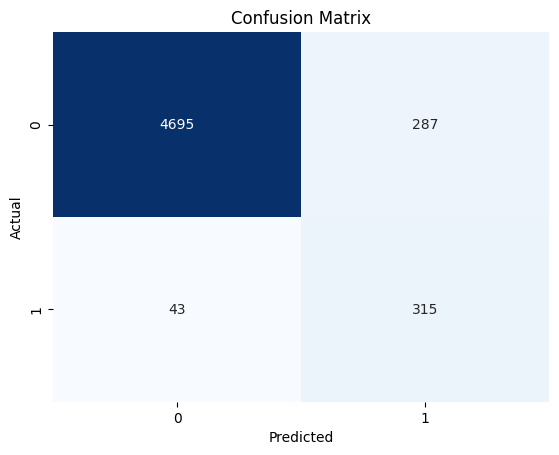

In [76]:
xgboost_combined_smoteenn_result = evaluate(X_test, y_test, grid)

##### Result

In [ ]:
# xgboost_sampling_techniques = {
#     #Oversampling
#     "RandomOverSampler": xgboost_over_random_result,
#     "ADASYN": xgboost_over_adasyn_result,
#     #Downsampling
#     "RandomUnderSampler": xgboost_under_random_result,
#     "TomekLinks": xgboost_under_tomeklinks_result,
#     #Combines over and down sampling
#     "SMOTEENN": xgboost_combined_smoteenn_result
# }

# xgboost_df = grid_results_to_dataframe(xgboost_sampling_techniques, entity="Sampler")

In [ ]:
# filtered_df = df_grid_results[df_grid_results["model"] == "XGBoost"]
# filtered_df = filtered_df.rename(columns={"model": "Sampler"})

# filtered_df["Sampler"] = "smote"

# xgboost_df = pd.concat([xgboost_df, filtered_df], ignore_index=True)

In [ ]:
# xgboost_sampler_df = pd.read_csv('results/xgboost_sampler_results.csv', index_col=False)

# xgboost_sampler_df = pd.concat([xgboost_sampler_df, grid_results_to_dataframe({"without":xgboost_result_without_smote}, entity="Sampler")], ignore_index=True)
# xgboost_df = xgboost_sampler_df
# xgboost_df

In [13]:
xgboost_df = pd.read_csv('results/xgboost_sampler_results.csv', index_col=False)
show(xgboost_df, buttons=["columnsToggle"])

- Smoteenn best f2score
- RandomUnderSampler had the highest recall, but the the precision wasnt very good

In [14]:
plot_metrics(xgboost_df)

In [25]:
#xgboost_df.to_csv("results/xgboost_sampler_results.csv", index=False)

#### **=== SVM ===**

In [92]:
param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'model__class_weight': [None, 'balanced']
}

##### Random Oversampling

In [93]:
model = SVC(random_state=SEED_VALUE, probability=True)
grid = create_grid_search(model, sampling_techniques["RandomOverSampler"], param_grid)
grid.fit(X_train_all, y_train_all)
grid

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('technique',
                                        RandomOverSampler(random_state=42,
                                                          sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__class_weight': [None, 'balanced'],
                         'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                         'model__kernel': ['linear', 'rbf']},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__C': 1, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best Grid Search Score: 0.7654
Accuracy  : 0.9206
Precision : 0.4554
Recall    : 0.9413
F1-Score  : 0.6138
Log-Loss  : 0.2034
AUC-ROC   : 0.9752
F2-Score   : 0.7758


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      4982
           1       0.46      0.94      0.61       358

    accuracy                           0.92      5340
   macro avg       0.73      0.93      0.78      5340
weighted avg       0.96      0.92      0.93      5340



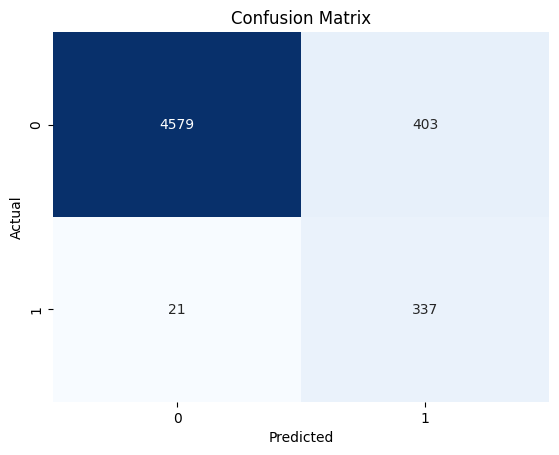

In [ ]:
svm_over_random_result = evaluate(X_test, y_test, grid)

##### ADASYN

In [95]:
model = SVC(random_state=SEED_VALUE, probability=True)
grid = create_grid_search(model, sampling_techniques["ADASYN"], param_grid)
grid.fit(X_train_all, y_train_all)
grid

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('technique',
                                        ADASYN(random_state=42,
                                               sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__class_weight': [None, 'balanced'],
                         'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                         'model__kernel': ['linear', 'rbf']},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__C': 100, 'model__class_weight': 'balanced', 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Best Grid Search Score: 0.7377
Accuracy  : 0.8959
Precision : 0.3883
Recall    : 0.9609
F1-Score  : 0.5531
Log-Loss  : 0.2715
AUC-ROC   : 0.9725
F2-Score   : 0.7420


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      4982
           1       0.39      0.96      0.55       358

    accuracy                           0.90      5340
   macro avg       0.69      0.93      0.75      5340
weighted avg       0.96      0.90      0.92      5340



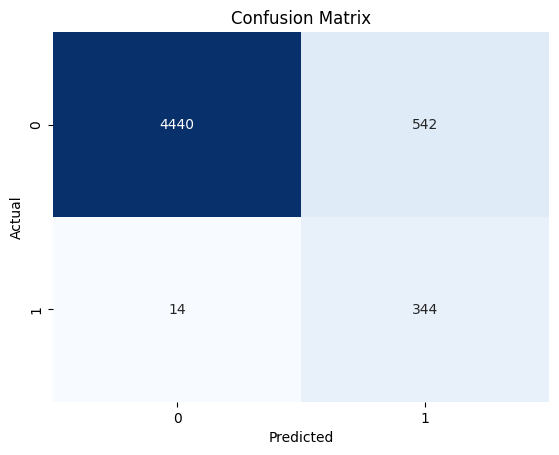

In [ ]:
svm_over_adasyn_result = evaluate(X_test, y_test, grid)

##### RandomUnderSampler

In [97]:
model = SVC(random_state=SEED_VALUE, probability=True)
grid = create_grid_search(model, sampling_techniques["RandomUnderSampler"], param_grid)
grid.fit(X_train_all, y_train_all)
grid

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('technique',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__class_weight': [None, 'balanced'],
                         'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                         'model__kernel': ['linear', 'rbf']},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__C': 100, 'model__class_weight': None, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
Best Grid Search Score: 0.7616
Accuracy  : 0.9189
Precision : 0.4501
Recall    : 0.9441
F1-Score  : 0.6096
Log-Loss  : 0.2267
AUC-ROC   : 0.9773
F2-Score   : 0.7742


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.92      0.95      4982
           1       0.45      0.94      0.61       358

    accuracy                           0.92      5340
   macro avg       0.72      0.93      0.78      5340
weighted avg       0.96      0.92      0.93      5340



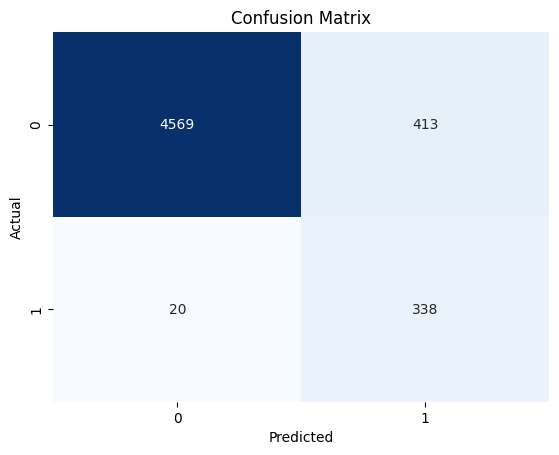

In [ ]:
svm_under_random_result = evaluate(X_test, y_test, grid)

##### TomekLinks

In [99]:
model = SVC(random_state=SEED_VALUE, probability=True)
grid = create_grid_search(model, sampling_techniques["TomekLinks"], param_grid)
grid.fit(X_train_all, y_train_all)
grid

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('technique',
                                        TomekLinks(n_jobs=-1,
                                                   sampling_strategy='majority')),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__class_weight': [None, 'balanced'],
                         'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                         'model__kernel': ['linear', 'rbf']},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__C': 10, 'model__class_weight': 'balanced', 'model__gamma': 1, 'model__kernel': 'rbf'}
Best Grid Search Score: 0.7656
Accuracy  : 0.9206
Precision : 0.4549
Recall    : 0.9302
F1-Score  : 0.6110
Log-Loss  : 0.0983
AUC-ROC   : 0.9763
F2-Score   : 0.7694


Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      4982
           1       0.45      0.93      0.61       358

    accuracy                           0.92      5340
   macro avg       0.72      0.93      0.78      5340
weighted avg       0.96      0.92      0.93      5340



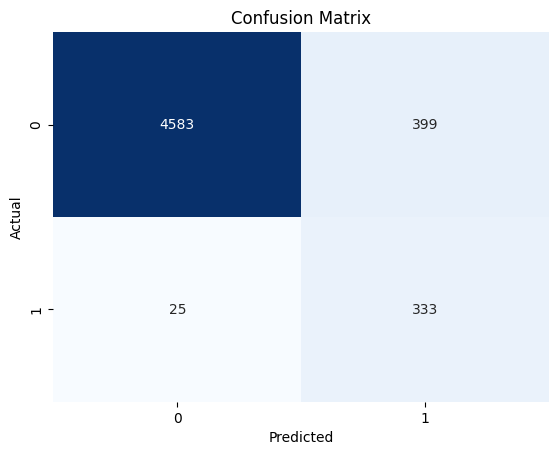

In [ ]:
svm_under_tomeklinks_result = evaluate(X_test, y_test, grid)

##### SMOTEENN

In [101]:
model = SVC(random_state=SEED_VALUE, probability=True)
grid = create_grid_search(model, sampling_techniques["SMOTEENN"], param_grid)
grid.fit(X_train_all, y_train_all)
grid

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('technique',
                                        SMOTEENN(random_state=42,
                                                 sampling_strategy=1)),
                                       ('scale', MinMaxScaler()),
                                       ('model',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__class_weight': [None, 'balanced'],
                         'model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                         'model__kernel': ['linear', 'rbf']},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=1)

Evaluation Metrics
Best Parameters : {'model__C': 1, 'model__class_weight': 'balanced', 'model__gamma': 1, 'model__kernel': 'rbf'}
Best Grid Search Score: 0.7509
Accuracy  : 0.9051
Precision : 0.4106
Recall    : 0.9553
F1-Score  : 0.5743
Log-Loss  : 0.4450
AUC-ROC   : 0.9748
F2-Score   : 0.7550


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      4982
           1       0.41      0.96      0.57       358

    accuracy                           0.91      5340
   macro avg       0.70      0.93      0.76      5340
weighted avg       0.96      0.91      0.92      5340



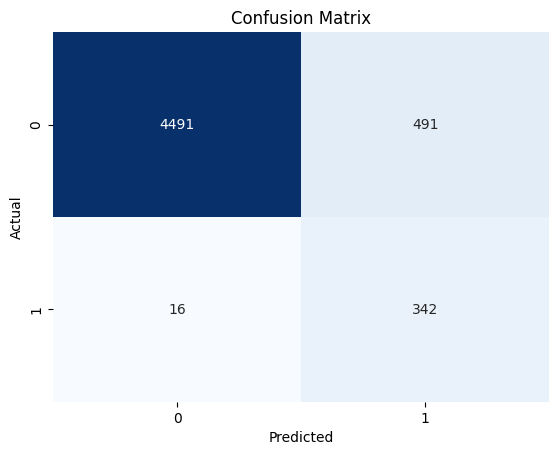

In [ ]:
svm_combined_smoteenn_result = evaluate(X_test, y_test, grid)

##### Results

In [ ]:
# svm_sampling_techniques = {
#     #Oversampling
#     "RandomOverSampler": svm_over_random_result,
#     "ADASYN": svm_over_adasyn_result,
#     #Downsampling
#     "RandomUnderSampler": svm_under_random_result,
#     "TomekLinks": svm_under_tomeklinks_result,
#     #Combines over and down sampling
#     "SMOTEENN": svm_combined_smoteenn_result
# }

# svm_df = grid_results_to_dataframe(svm_sampling_techniques, entity="Sampler")

In [ ]:
# filtered_df = df_grid_results[df_grid_results["model"] == "SVM"]
# filtered_df = filtered_df.rename(columns={"model": "Sampler"})

# filtered_df["Sampler"] = "smote"

# svm_df = pd.concat([svm_df, filtered_df], ignore_index=True)

In [ ]:
# svm_sampler_df = pd.read_csv('results/svm_sampler_results.csv', index_col=False)

# svm_sampler_df = pd.concat([svm_sampler_df, grid_results_to_dataframe({"without":svm_result_without_smote}, entity="Sampler")], ignore_index=True)
# svm_df = svm_sampler_df
# svm_df

In [ ]:
svm_df = pd.read_csv('results/svm_sampler_results.csv', index_col=False)
show(svm_df, buttons=["columnsToggle"])

- Smote had the highest f2score
- None peformed better in the overall

In [ ]:
plot_metrics(svm_df)

In [ ]:
#svm_df.to_csv("results/svm_sampler_results.csv", index=False)

## Final Tests

In [2]:
import ast
# tranform best_params from .csv to actual classifier params
def set_classifier_params(param_string, classifier):
    params = ast.literal_eval(param_string)
    stripped_params = {key.replace("model__", ""): value for key, value in params.items()}
    classifier.set_params(**stripped_params)
    return classifier

In [1]:
def get_best_pipeline_based_on(df, metric, clf):
        best_params, sampler =  df.iloc[df[metric].idxmax()][['best_params','Sampler']]
        model = set_classifier_params(best_params, clf)
        
        return create_pipeline_with(sampling_techniques[sampler], model) if (sampler != "without") else create_pipeline_scaler_model(model)

In [ ]:
#===== svm classifier
svm_pipe = get_best_pipeline_based_on(pd.read_csv('results/svm_sampler_results.csv', index_col=False), 
                                'f2_score', 
                                SVC(random_state=SEED_VALUE, probability=True))
print(svm_pipe)
#===== rf classifier
rf_pipe = get_best_pipeline_based_on(pd.read_csv('results/rf_sampler_results.csv', index_col=False), 
                                'f2_score', 
                                RandomForestClassifier(random_state=SEED_VALUE, n_jobs=-1))
print(rf_pipe)
#===== xgboost classifier
xgboost_pipe = get_best_pipeline_based_on(pd.read_csv('results/xgboost_sampler_results.csv', index_col=False), 
                                'f2_score', 
                                XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
print(xgboost_pipe)

Pipeline(steps=[('technique', SMOTE(random_state=42, sampling_strategy=1)),
                ('scale', MinMaxScaler()),
                ('model',
                 SVC(C=10, gamma='auto', probability=True, random_state=42))])
Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=5,
                                        n_estimators=50, n_jobs=-1,
                                        random_state=42))])
Pipeline(steps=[('technique', SMOTEENN(random_state=42, sampling_strategy=1)),
                ('scale', MinMaxScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='loglos

In [135]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, average_precision_score
#precision-recall curves
def evaluate_pipelines(pipelines, X, y):
    plt.figure(figsize=(10, 7))

    for pipeline in pipelines:
        model_name = type(pipeline.named_steps['model']).__name__

        # cross-validation
        y_scores = cross_val_predict(pipeline, X, y, cv=10, method='predict_proba')[:, 1]

        # precision-recall curve
        precision, recall, _ = precision_recall_curve(y, y_scores)
        avg_precision = average_precision_score(y, y_scores)

        plt.plot(recall, precision, label=f"{model_name}: AP={avg_precision:.2f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Comparison')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

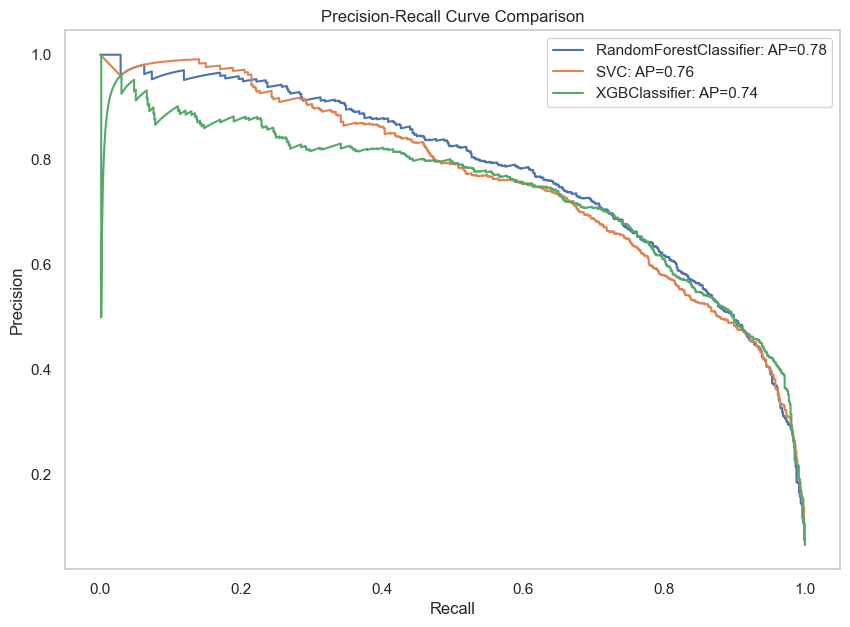

In [ ]:
pipelines = [rf_pipe, svm_pipe, xgboost_pipe]

evaluate_pipelines(pipelines, X_train_all, y_train_all)

In [146]:
def get_best_models(file_paths, metric='f2_score'):
    best_models = []

    for file_path in file_paths:
        df = pd.read_csv(file_path, index_col=False)

        best_model = df.iloc[df[metric].idxmax()].copy()

        best_model['model'] = file_path.split('/')[1].split('_')[0]

        best_models.append(best_model)

    best_models_df = pd.DataFrame(best_models)
    columns_order = ['model'] + [col for col in best_models_df.columns if col != 'model']
    best_models_df = best_models_df[columns_order]

    return best_models_df.reset_index(drop=True)

In [ ]:
file_paths = [
    'results/svm_sampler_results.csv', 
    'results/rf_sampler_results.csv', 
    'results/xgboost_sampler_results.csv'
]

best_models_df = get_best_models(file_paths)
show(best_models_df, buttons=["columnsToggle"])

**Result: SVM or RandomForest**
> SVM had the best f2-score and an extremely good recall of 94%
>
>> But the precision wasn't that good, it was only 45%
>> Had the second best AP of precision-recall curve

> RF had the best AP of precision-recall curve
>> The f2_score was slightly less than SVM

## Export best pipeline

In [12]:
rf_pipe = get_best_pipeline_based_on(pd.read_csv('results/rf_sampler_results.csv', index_col=False), 
                                'f2_score', 
                                RandomForestClassifier(random_state=SEED_VALUE, n_jobs=-1))

rf_pipe

Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=5,
                                        n_estimators=50, n_jobs=-1,
                                        random_state=42))])

In [13]:
rf_pipe.fit(X_train_all, y_train_all)

Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=5,
                                        n_estimators=50, n_jobs=-1,
                                        random_state=42))])

In [14]:
import pickle

pickle.dump(rf_pipe, open("best_pipeline.pkl", 'wb'))

## Technical Debt Score/Interest/Severity

In [ ]:
rf_pipe = pickle.load(open("best_pipeline.pkl", "rb"))
rf_pipe

Pipeline(steps=[('scale', MinMaxScaler()),
                ('model',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=5,
                                        n_estimators=50, n_jobs=-1,
                                        random_state=42))])

In [ ]:
rf_pipe.fit(X_train_all, y_train_all)

# feature importance for each feature
feature_importances = pd.Series(rf_pipe.named_steps['model'].feature_importances_, index=X_train_all.columns).sort_values(ascending=False)

print("Random Forest Feature Importances:")
print(feature_importances)

Random Forest Feature Importances:
ncloc_cloc                      0.278943
wmc                             0.180012
total_variables                 0.118249
rfc                             0.083302
max_nested_blocks               0.041485
lcom                            0.039104
total_methods                   0.037739
comment_lines_cloc_density      0.034512
total_refactorings              0.024715
cbo                             0.022657
commits_count                   0.022309
duplicated_lines_cpd_density    0.021369
code_churn_avg                  0.020812
contributors_experience         0.018602
contributors_count              0.018551
issue_tracker_issues            0.018044
dit                             0.010132
hunks_count                     0.009464
dtype: float64


In [18]:
weights_of_each_feature = feature_importances

In [16]:
def calculate_debt_severity(entity_to_be_evaluated):

    debt_score = sum(entity_to_be_evaluated[feature] * weight for feature, weight in weights_of_each_feature.items())
    debt_score *= 100

    if debt_score < 20:
        severity = 'Low'
    elif debt_score < 40:
        severity = 'Medium'
    else:
        severity = 'High'
    
    return severity, debt_score

In [ ]:
def predict_and_estimate_severity(pipe, entitys_to_be_evaluated):
    predictions = pipe.predict(entitys_to_be_evaluated[FEATURES])
    results = []

    for i, has_debt in enumerate(predictions):

        entity_dict = {
            'Project': entitys_to_be_evaluated.iloc[i]['project_name'],
            'Class': entitys_to_be_evaluated.iloc[i]['class_name'],
            'Actual TD': (True if ((entitys_to_be_evaluated.iloc[i]['Max-Ruler']) == 1) else False)
            }

        if has_debt:
            # scaled row to calculate severity
            row_df = pd.DataFrame([entitys_to_be_evaluated.iloc[i][FEATURES]], columns=FEATURES)
            scaled_row = pipe.named_steps['scale'].transform(row_df)
            scaled_row = pd.DataFrame(scaled_row, columns=FEATURES).iloc[0]

            severity, deb_score = calculate_debt_severity(scaled_row)
            
            entity_dict.update({
                'Predicted TD': True, 
                'Severity': severity,
                'Debt_Score': round(deb_score, 2)
                })
        else:
            entity_dict.update({
                'Predicted TD': False, 
                'Severity': '-',
                'Debt_Score': 0
                })
            
        results.append(entity_dict)

    return pd.DataFrame(results)

### Prediction Tests

In [18]:
df_test = pd.read_csv('dataset_with_project_names.csv', index_col=False)

sample_td = df_test[df_test['Max-Ruler'] == 1].sample(n=5, random_state=SEED_VALUE)
sample_not_td = df_test[df_test['Max-Ruler'] == 0].sample(n=5, random_state=SEED_VALUE)

final_sample = pd.concat([sample_td, sample_not_td], ignore_index=True)
final_sample

class_name project_name  commits_count  \
0                          Type3Font.java       pdfbox          123.0   
1            JmxBroadcasterLifecycle.java   deltaspike           86.0   
2                               Like.java   deltaspike           24.0   
3                IngresMergerFactory.java      cayenne           15.0   
4                     ServerInRegion.java      jclouds           94.0   
5                             Slider.java       libgdx            3.0   
6                  HttpRemoteService.java      cayenne            4.0   
7                     LwjglAWTCanvas.java       libgdx            8.0   
8               ContentLayoutManager.java          fop           13.0   
9  FilteringHlsPlaylistParserFactory.java    exoplayer           14.0   

   code_churn_avg  contributors_count  contributors_experience  hunks_count  \
0             4.0                 4.0                    64.70          3.0   
1            11.0                 6.0                    38.55          3.0   
2            23.0                 4.0                    92.31          2.0   
3            19.0                 3.0                    96.65          2.0   
4            12.0                21.0                    44.97          2.0   
5            26.0                 1.0                   100.00          1.0   
6            12.0                 2.0                    97.50          1.5   
7            20.0                 4.0                    94.15          1.0   
8             7.0                 5.0                    84.68          1.0   
9            17.0                 7.0                    72.26          1.0   

   issue_tracker_issues   cbo    wmc  ...    rfc    lcom  total_methods  \
0                 141.0  28.0  125.0  ...  101.0   186.0           21.0   
1                  12.0  44.0  126.0  ...   96.0   412.0           36.0   
2                  11.0   9.0   42.0  ...   15.0     0.0           16.0   
3                   2.0  11.0   37.0  ...   49.0    64.0           12.0   
4                  16.0  17.0  321.0  ...   66.0  1796.0           61.0   
5                   0.0   4.0   10.0  ...    2.0    45.0           10.0   
6                   0.0   4.0    3.0  ...    4.0     3.0            3.0   
7                   0.0   5.0   37.0  ...   31.0     0.0           29.0   
8                 149.0   0.0    7.0  ...    4.0     0.0            3.0   
9                   1.0  19.0   44.0  ...   32.0     0.0            7.0   

   max_nested_blocks  total_variables  total_refactorings  ncloc_cloc  \
0                6.0             69.0               276.0       450.0   
1                5.0            128.0               545.0       787.0   
2                1.0             26.0                43.0       316.0   
3                4.0             37.0                29.0       202.0   
4                4.0             49.0               117.0       988.0   
5                0.0              2.0                 1.0        48.0   
6                0.0              2.0                 1.0        21.0   
7                2.0              4.0                 1.0       116.0   
8                1.0              5.0                 1.0        34.0   
9                6.0             39.0                 1.0       187.0   

   Max-Ruler  duplicated_lines_cpd_density  comment_lines_cloc_density  
0        1.0                      0.000000                    7.597536  
1        1.0                      5.463787                    8.275058  
2        1.0                      0.000000                   29.621381  
3        1.0                     15.841584                   22.007722  
4        1.0                     16.902834                    2.081269  
5        0.0                      0.000000                   26.153846  
6        0.0                      0.000000                   46.153846  
7        0.0                      0.000000                    6.451613  
8        0.0                      0.000000                   57.500000

In [22]:
sample_td = df_test[df_test['Max-Ruler'] == 1].sample(n=5, random_state=66)
sample_not_td = df_test[df_test['Max-Ruler'] == 0].sample(n=5, random_state=66)

final_sample = pd.concat([sample_td, sample_not_td], ignore_index=True)
predict_and_estimate_severity(rf_pipe, final_sample)

Project                               Class  Actual TD  Predicted TD  \
0    opennlp    LanguageDetectorModelLoader.java       True          True   
1        fop                 RendererConfig.java       True         False   
2     pdfbox                    COSDocument.java       True          True   
3     pdfbox          GouraudShadingContext.java       True         False   
4        fop  RepeatablePageMasterReference.java       True          True   
5    opennlp        TokenizerCrossValidator.java      False         False   
6      maven              DependencyContext.java      False         False   
7     libgdx                btStorageResult.java      False         False   
8  exoplayer            LibvpxVideoRenderer.java      False         False   
9     libgdx                     TextButton.java      False         False   

  Severity  Debt_Score  
0   Medium       24.35  
1        -        0.00  
2     High       47.40  
3        -        0.00  
4      Low       19.47  
5        -        0.00  
6        -        0.00  
7        -        0.00  
8        -        0.00  
9        -        0.00

### Test - Clustering for severity

In [170]:
df_for_cluster = pd.read_csv('dataset_final.csv', index_col=False)
#df_for_cluster = df_for_cluster[df_for_cluster['Max-Ruler'] == 1]

df_for_cluster.head(5)

Max-Ruler  commits_count  code_churn_avg  contributors_count  \
0          1           11.0            65.0                 3.0   
1          1           34.0            29.0                 8.0   
2          1          184.0             5.0                12.0   
3          1           21.0            17.0                 6.0   
4          0           38.0            10.0                 6.0   

   contributors_experience  hunks_count  issue_tracker_issues   cbo    wmc  \
0                    81.63          1.0                    16   3.0  108.0   
1                    73.57          4.5                   217  14.0   46.0   
2                    37.28          2.0                    40  34.0  188.0   
3                    53.60          1.0                     9   9.0  103.0   
4                    52.14          2.5                     1  10.0   19.0   

   dit    rfc    lcom  total_methods  max_nested_blocks  total_variables  \
0  1.0   74.0   774.0           40.0                3.0             66.0   
1  6.0  130.0   144.0           20.0                4.0             93.0   
2  1.0  163.0  1635.0           59.0                5.0            108.0   
3  1.0   36.0   183.0           26.0                4.0             30.0   
4  6.0   74.0    55.0           14.0                2.0             31.0   

   total_refactorings  ncloc_cloc  duplicated_lines_cpd_density  \
0                  30       410.0                           0.0   
1                  41       799.0                           0.0   
2                 276       698.0                           0.0   
3                  14       310.0                           0.0   
4                  31       276.0                           0.0   

   comment_lines_cloc_density  
0                   35.736677  
1                    4.540024  
2                   18.171161  
3                    0.958466  
4                   14.285714

In [171]:
X_all = df_for_cluster[FEATURES]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_all)

df_for_cluster[FEATURES] = X_scaled

df_for_cluster = df_for_cluster[df_for_cluster['Max-Ruler'] == 1]
df_for_cluster

Max-Ruler  commits_count  code_churn_avg  contributors_count  \
0              1       0.031646        0.043366            0.045455   
1              1       0.104430        0.020065            0.159091   
2              1       0.579114        0.004531            0.250000   
3              1       0.063291        0.012298            0.113636   
5              1       0.047468        0.020712            0.068182   
...          ...            ...             ...                 ...   
16835          1       0.313291        0.009709            0.181818   
16842          1       0.091772        0.016181            0.090909   
16843          1       0.031646        0.023948            0.068182   
16847          1       0.047468        0.016828            0.068182   
16864          1       0.113924        0.014239            0.090909   

       contributors_experience  hunks_count  issue_tracker_issues       cbo  \
0                     0.776955     0.037736              0.013479  0.027523   
1                     0.679092     0.169811              0.182814  0.128440   
2                     0.238465     0.075472              0.033698  0.311927   
3                     0.436620     0.037736              0.007582  0.082569   
5                     0.798324     0.075472              0.001685  0.073394   
...                        ...          ...                   ...       ...   
16835                 0.667557     0.132075              0.021061  0.376147   
16842                 0.295289     0.075472              0.000842  0.247706   
16843                 0.730695     0.037736              0.000000  0.073394   
16847                 0.906872     0.169811              0.000000  0.155963   
16864                 0.594585     0.075472              0.002527  0.073394   

            wmc       dit       rfc      lcom  total_methods  \
0      0.238411  0.000000  0.252560  0.103159       0.156250   
1      0.101545  0.098039  0.443686  0.019192       0.078125   
2      0.415011  0.000000  0.556314  0.217913       0.230469   
3      0.227373  0.000000  0.122867  0.024390       0.101562   
5      0.116998  0.098039  0.266212  0.012528       0.066406   
...         ...       ...       ...       ...            ...   
16835  0.368653  0.000000  0.563140  0.102759       0.214844   
16842  0.077263  0.137255  0.307167  0.005731       0.042969   
16843  0.075055  0.019608  0.081911  0.009330       0.050781   
16847  0.064018  0.058824  0.061433  0.022524       0.074219   
16864  0.247241  0.098039  0.290102  0.066773       0.148438   

       max_nested_blocks  total_variables  total_refactorings  ncloc_cloc  \
0               0.142857         0.216393            0.029297    0.214624   
1               0.190476         0.304918            0.040039    0.419253   
2               0.238095         0.354098            0.269531    0.366123   
3               0.190476         0.098361            0.013672    0.162020   
5               0.285714         0.124590            0.013672    0.181483   
...                  ...              ...                 ...         ...   
16835           0.238095         0.236066            0.004883    0.391373   
16842           0.476190         0.150820            0.000977    0.268806   
16843           0.142857         0.137705            0.000977    0.164124   
16847           0.047619         0.019672            0.002930    0.148343   
16864           0.238095         0.157377            0.000977    0.224619   

       duplicated_lines_cpd_density  comment_lines_cloc_density  
0                          0.000000                    0.379702  
1                          0.000000                    0.048238  
2                          0.000000                    0.193069  
3                          0.000000                    0.010184  
5                          0.000000                    0.136149  
...                             ...                         ...  
16835                      0.000000              

In [172]:
df_for_cluster = df_for_cluster.drop(columns=['Max-Ruler'])
df_for_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1193 entries, 0 to 16864
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   commits_count                 1193 non-null   float64
 1   code_churn_avg                1193 non-null   float64
 2   contributors_count            1193 non-null   float64
 3   contributors_experience       1193 non-null   float64
 4   hunks_count                   1193 non-null   float64
 5   issue_tracker_issues          1193 non-null   float64
 6   cbo                           1193 non-null   float64
 7   wmc                           1193 non-null   float64
 8   dit                           1193 non-null   float64
 9   rfc                           1193 non-null   float64
 10  lcom                          1193 non-null   float64
 11  total_methods                 1193 non-null   float64
 12  max_nested_blocks             1193 non-null   float64
 13  total_v

In [173]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=SEED_VALUE)
df_for_cluster['severity'] = kmeans.fit_predict(df_for_cluster)

In [174]:
df_for_cluster.head(5)

commits_count  code_churn_avg  contributors_count  contributors_experience  \
0       0.031646        0.043366            0.045455                 0.776955   
1       0.104430        0.020065            0.159091                 0.679092   
2       0.579114        0.004531            0.250000                 0.238465   
3       0.063291        0.012298            0.113636                 0.436620   
5       0.047468        0.020712            0.068182                 0.798324   

   hunks_count  issue_tracker_issues       cbo       wmc       dit       rfc  \
0     0.037736              0.013479  0.027523  0.238411  0.000000  0.252560   
1     0.169811              0.182814  0.128440  0.101545  0.098039  0.443686   
2     0.075472              0.033698  0.311927  0.415011  0.000000  0.556314   
3     0.037736              0.007582  0.082569  0.227373  0.000000  0.122867   
5     0.075472              0.001685  0.073394  0.116998  0.098039  0.266212   

       lcom  total_methods  max_nested_blocks  total_variables  \
0  0.103159       0.156250           0.142857         0.216393   
1  0.019192       0.078125           0.190476         0.304918   
2  0.217913       0.230469           0.238095         0.354098   
3  0.024390       0.101562           0.190476         0.098361   
5  0.012528       0.066406           0.285714         0.124590   

   total_refactorings  ncloc_cloc  duplicated_lines_cpd_density  \
0            0.029297    0.214624                           0.0   
1            0.040039    0.419253                           0.0   
2            0.269531    0.366123                           0.0   
3            0.013672    0.162020                           0.0   
5            0.013672    0.181483                           0.0   

   comment_lines_cloc_density  severity  
0                    0.379702         1  
1                    0.048238         1  
2                    0.193069         2  
3                    0.010184         0  
5                    0.136149         1

#### Predict Severity with ml

In [175]:
X = df_for_cluster[FEATURES]
y = df_for_cluster['severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED_VALUE)

In [176]:
classifier = RandomForestClassifier(random_state=SEED_VALUE)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [177]:
y_pred = classifier.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

Classification Report:
               precision    recall  f1-score   support

         Low       0.95      0.98      0.96        91
      Medium       0.97      1.00      0.99       109
        High       0.97      0.82      0.89        39

    accuracy                           0.96       239
   macro avg       0.96      0.93      0.95       239
weighted avg       0.96      0.96      0.96       239



In [194]:
def calculate_debt_severity_with_model(entity_to_be_evaluated):
    severity_mapping = {0: 'Low', 
                        1: 'Medium', 
                        2: 'High'}
    
    #predict the severity
    severity = classifier.predict(entity_to_be_evaluated)[0]
    #confidence score as percentage
    probability_score = max(classifier.predict_proba(entity_to_be_evaluated)[0]) * 100
    
    return severity_mapping[severity], probability_score

In [190]:
def predict_and_estimate_severity_model(pipe, entitys_to_be_evaluated):
    predictions = pipe.predict(entitys_to_be_evaluated[FEATURES])
    results = []

    for i, has_debt in enumerate(predictions):
        if has_debt:
            # scaled row to calculate severity
            row_df = pd.DataFrame([entitys_to_be_evaluated.iloc[i][FEATURES]], columns=FEATURES)
            scaled_row = pipe.named_steps['scale'].transform(row_df)
            scaled_row = pd.DataFrame(scaled_row, columns=FEATURES)

            severity, deb_score = calculate_debt_severity_with_model(scaled_row)
            results.append({'Project': entitys_to_be_evaluated.iloc[i]['project_name'],
                            'Class': entitys_to_be_evaluated.iloc[i]['class_name'],
                            'Technical_Debt': True, 
                            'Severity': severity,
                            'Prob': round(deb_score, 2)})
        else:
            results.append({'Project': entitys_to_be_evaluated.iloc[i]['project_name'],
                            'Class': entitys_to_be_evaluated.iloc[i]['class_name'],
                            'Technical_Debt': False, 
                            'Severity': '-',
                            'Prob': 0})

    return pd.DataFrame(results)

**===TEST===**

In [193]:
sample_td = df_test[df_test['Max-Ruler'] == 1].sample(n=5, random_state=66)
sample_not_td = df_test[df_test['Max-Ruler'] == 0].sample(n=5, random_state=66)

final_sample = pd.concat([sample_td, sample_not_td], ignore_index=True)
predict_and_estimate_severity_model(rf_pipe, final_sample)

Project                               Class  Technical_Debt Severity  \
0    opennlp    LanguageDetectorModelLoader.java            True      Low   
1        fop                 RendererConfig.java           False        -   
2     pdfbox                    COSDocument.java            True     High   
3     pdfbox          GouraudShadingContext.java           False        -   
4        fop  RepeatablePageMasterReference.java            True   Medium   
5    opennlp        TokenizerCrossValidator.java           False        -   
6      maven              DependencyContext.java           False        -   
7     libgdx                btStorageResult.java           False        -   
8  exoplayer            LibvpxVideoRenderer.java           False        -   
9     libgdx                     TextButton.java           False        -   

   Prob  
0  75.0  
1   0.0  
2  99.0  
3   0.0  
4  93.0  
5   0.0  
6   0.0  
7   0.0  
8   0.0  
9   0.0

## Trash

### Stacking and Voting Classifiers

Chose the classifier with highest f2score? Lowest FN (highest recall)? Best Accuracy? Mix them?

In [23]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression

In [ ]:
svm_pipeline = create_pipeline_with(sampling_techniques["ADASYN"], SVC(C=100, class_weight='balanced', gamma='auto', kernel='rbf',probability=True))
svm_pipeline.fit(X_train_all, y_train_all)
svm = svm_pipeline.named_steps['model']

rf_pipeline = create_pipeline_with(sampling_techniques["RandomUnderSampler"], RandomForestClassifier(criterion='gini', max_depth=None, min_samples_leaf=1, n_estimators=10))
rf_pipeline.fit(X_train_all, y_train_all)
rf = rf_pipeline.named_steps['model']

xgboost_pipeline = create_pipeline_with(sampling_techniques["RandomUnderSampler"], XGBClassifier(colsample_bytree = 1, learning_rate = 0.2, max_depth = 3, n_estimators = 50, subsample = 0.6,use_label_encoder=False, eval_metric='logloss'))
xgboost_pipeline.fit(X_train_all, y_train_all)
xgboost = xgboost_pipeline.named_steps['model']

In [ ]:
stack_voting_models = [
    ('svm', svm),
    ('rf', rf),
    ('xgboost', xgboost)
]

#### Voting

Evaluation Metrics
Accuracy  : 0.9618
Precision : 0.8969
Recall    : 0.4860
F1-Score  : 0.6304
Log-Loss  : 0.1153
AUC-ROC   : 0.9785
F2-Score   : 0.5351


Classification Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4982
           1       0.90      0.49      0.63       358

    accuracy                           0.96      5340
   macro avg       0.93      0.74      0.81      5340
weighted avg       0.96      0.96      0.96      5340



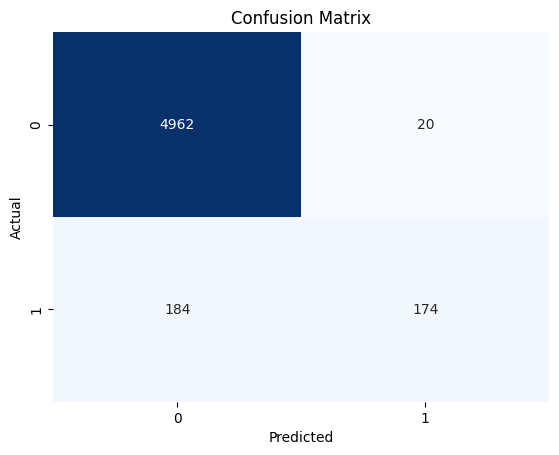

In [41]:
voting_clf = VotingClassifier(estimators=stack_voting_models,
                              voting='soft')  # Use 'hard' for majority voting or 'soft' for probability-based voting
voting_clf.fit(X_train_all, y_train_all)
res = evaluate(X_test, y_test, model=voting_clf, print_res=True)

#### Stacking

Evaluation Metrics
Accuracy  : 0.9648
Precision : 0.8102
Recall    : 0.6201
F1-Score  : 0.7025
Log-Loss  : 0.0990
AUC-ROC   : 0.9794
F2-Score   : 0.6506


Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4982
           1       0.81      0.62      0.70       358

    accuracy                           0.96      5340
   macro avg       0.89      0.80      0.84      5340
weighted avg       0.96      0.96      0.96      5340



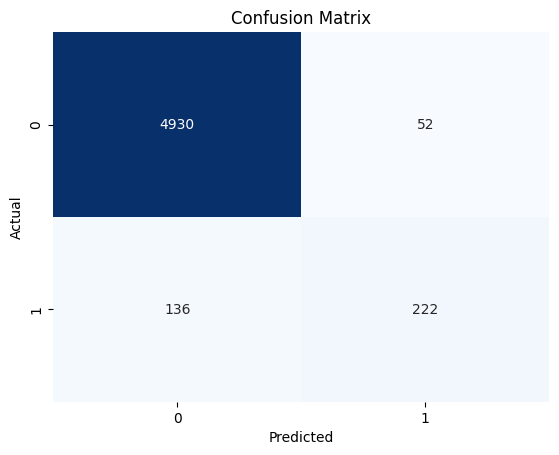

In [42]:
meta_learner = LogisticRegression()
stacking_clf = StackingClassifier(estimators=stack_voting_models, final_estimator=meta_learner)
stacking_clf.fit(X_train_all, y_train_all)
res = evaluate(X_test, y_test, model=stacking_clf, print_res=True)